# Signal Validation: ggH → H → Za (NanoAODv15)

Validation plots for the locally produced NanoAODv15 signal sample with CMSSW.

**Signal process:** $gg \to H(125) \to Z(\to \ell^+\ell^-) + a(\to \text{tracks})$ at $\sqrt{s} = 13.6$ TeV

Uses `uproot` + `awkward` for columnar analysis and `mplhep` for CMS-style plotting.

In [3]:
import sys
!{sys.executable} -m pip install -U awkward uproot vector hist mplhep

In [4]:
import uproot
import awkward as ak
import numpy as np
import vector
import hist
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob
import gc

# Print versions for reproducibility
for mod in [uproot, ak, np, vector, hist, hep]:
    print(f"{mod.__name__:12s} {mod.__version__}")

vector.register_awkward()

uproot       5.7.1
awkward      2.9.0
numpy        2.4.2
vector       1.8.0
hist         2.10.1
mplhep       1.1.0


In [6]:
# ── CMS plot style & configuration ─────────────────────────────────────────────
hep.style.use(hep.style.CMS)
plt.rcParams.update({"figure.figsize": (10, 8), "font.size": 16})

LUMI_TEXT = ""  # no luminosity for private MC
MASS_A = 1.0   # GeV — signal hypothesis

# ── Memory management ──────────────────────────────────────────────────────────
MAX_FILES = None         # Limit ROOT files loaded (None = all); reduce if hitting OOM
PAIR_CHUNK_SIZE = 5000   # Events per chunk for PFCands OS-pair computation

def cms_label(ax, label="Simulation Work in Progress"):
    """Add CMS label to axes."""
    hep.cms.label(label, data=False, ax=ax, loc=0, fontsize=18, com=13.6)

def save_and_show(fig, name=None):
    """Tight-layout, optionally save, then show."""
    fig.tight_layout()
    if name:
        fig.savefig(name, dpi=150, bbox_inches="tight")
    plt.show()

## Load Signal NanoAOD

Read the NanoAODv15 file from the full-chain local production run. Print event count and available collections.

In [7]:
# ── Load NanoAOD ───────────────────────────────────────────────────────────────
all_files = sorted(glob("/pnfs/desy.de/cms/tier2/store/user/pgadow/ggH_HZa_signals/RunIII2024Summer24/ggH_HZa_mA1_0GeV/RunIII2024Summer24BTVNanoAllPF/260221_180921/0000/*.root"))
all_files = sorted(glob("/eos/user/p/pgadow/www/share/ggH_HZa_mA1_0GeV/*.root"))

if not all_files:
    raise RuntimeError("No ROOT files matched the glob. Check the path and permissions.")

files = all_files[:MAX_FILES] if MAX_FILES else all_files
if MAX_FILES:
    print(f"⚠ MAX_FILES={MAX_FILES}: using {len(files)} of {len(all_files)} available files")

# Open ONE file to inspect available branches
with uproot.open(files[0]) as f:
    tree = f["Events"]
    all_keys = set(tree.keys())

branches_to_read = [
    # GenPart
    "nGenPart", "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass",
    "GenPart_pdgId", "GenPart_status", "GenPart_statusFlags", "GenPart_genPartIdxMother",
    # Muons
    "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge",
    "Muon_mediumId", "Muon_pfRelIso04_all", "Muon_dxy", "Muon_dz",
    # Electrons
    "nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass",
    "Electron_charge", "Electron_cutBased", "Electron_pfRelIso03_all",
    "Electron_dxy", "Electron_dz",
    # Jets
    "nJet", "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
    "Jet_btagDeepFlavB",
    # MET
    "PuppiMET_pt", "PuppiMET_phi",
    # IsoTracks
    "nIsoTrack", "IsoTrack_pt", "IsoTrack_eta", "IsoTrack_phi",
    "IsoTrack_charge", "IsoTrack_pdgId",
    "IsoTrack_pfRelIso03_all", "IsoTrack_fromPV",
    "IsoTrack_isHighPurityTrack", "IsoTrack_dxy", "IsoTrack_dz",
]

# Discover PFCands branches (loaded lazily in the PFCands cell to save memory)
pf_keys = sorted([k for k in all_keys if k.startswith("PFCands_")])
print(f"\nPFCands branches found: {len(pf_keys)}")
if pf_keys:
    print("  ", pf_keys[:15], "..." if len(pf_keys) > 15 else "")
    pf_branches_to_read = [
        k for k in pf_keys
        if any(sub in k for sub in [
            "_pt", "_eta", "_phi", "_mass", "_charge", "_pdgId", "_dz", "_d0",
            "_pvAssocQuality", "_trkChi2", "_vertexChi2", "_fromPV"
        ])
    ]
    print(f"  {len(pf_branches_to_read)} PFCands branches prepared (loaded later to manage memory)")
else:
    pf_branches_to_read = []
    alt_collections = ["FsrPhoton", "LowPtElectron", "SoftActivityJet", "SubJet"]
    for coll in alt_collections:
        coll_keys = [k for k in all_keys if k.startswith(f"{coll}_")]
        if coll_keys:
            print(f"  Alternative collection found: {coll} ({len(coll_keys)} branches)")

HAS_PFCANDS = len(pf_keys) > 0

# Read core branches into awkward arrays (PFCands loaded lazily later)
events = uproot.concatenate(
    {f: "Events" for f in files},
    expressions=branches_to_read,
    library="ak",
)

print(f"\nFiles loaded: {len(files)}")
print(f"Events:       {len(events)}")
print(f"Memory note:  PFCands are NOT loaded here — loaded on demand in the PFCands cell")


PFCands branches found: 27
   ['PFCands_charge', 'PFCands_d0', 'PFCands_d0Err', 'PFCands_dz', 'PFCands_dzErr', 'PFCands_eta', 'PFCands_genCandIdx', 'PFCands_lostInnerHits', 'PFCands_lostOuterHits', 'PFCands_mass', 'PFCands_numberOfHits', 'PFCands_numberOfPixelHits', 'PFCands_pdgId', 'PFCands_phi', 'PFCands_pt'] ...
  12 PFCands branches prepared (loaded later to manage memory)

Files loaded: 41
Events:       41000
Memory note:  PFCands are NOT loaded here — loaded on demand in the PFCands cell


## Generator-Level Kinematic Distributions

Extract the Higgs ($H$, PDG 25), Z boson (PDG 23), and pseudoscalar $a$ (PDG 36) from the `GenPart` collection using status flags. Plot their $p_T$, $\eta$, and mass distributions.

In [8]:
# ── Extract gen-level particles ────────────────────────────────────────────────
genpart = ak.zip({
    "pt":     events.GenPart_pt,
    "eta":    events.GenPart_eta,
    "phi":    events.GenPart_phi,
    "mass":   events.GenPart_mass,
    "pdgId":  events.GenPart_pdgId,
    "status": events.GenPart_status,
    "statusFlags": events.GenPart_statusFlags,
    "motherIdx": events.GenPart_genPartIdxMother,
})

# isLastCopy flag = bit 13 of statusFlags
is_last_copy = (genpart.statusFlags & (1 << 13)) != 0

# Select gen-level particles (last copy)
gen_higgs = genpart[(abs(genpart.pdgId) == 25) & is_last_copy]
gen_Z     = genpart[(abs(genpart.pdgId) == 23) & is_last_copy]
gen_a     = genpart[(abs(genpart.pdgId) == 36) & is_last_copy]

# Also get gen-level leptons from Z decay (status 1 = stable)
gen_leptons = genpart[
    ((abs(genpart.pdgId) == 11) | (abs(genpart.pdgId) == 13)) &
    (genpart.status == 1) & is_last_copy
]

print(f"Gen Higgs per event: {ak.mean(ak.num(gen_higgs)):.1f}")
print(f"Gen Z per event:     {ak.mean(ak.num(gen_Z)):.1f}")
print(f"Gen a per event:     {ak.mean(ak.num(gen_a)):.1f}")
print(f"Gen leptons/event:   {ak.mean(ak.num(gen_leptons)):.1f}")

Gen Higgs per event: 1.0
Gen Z per event:     1.0
Gen a per event:     1.0
Gen leptons/event:   4.7


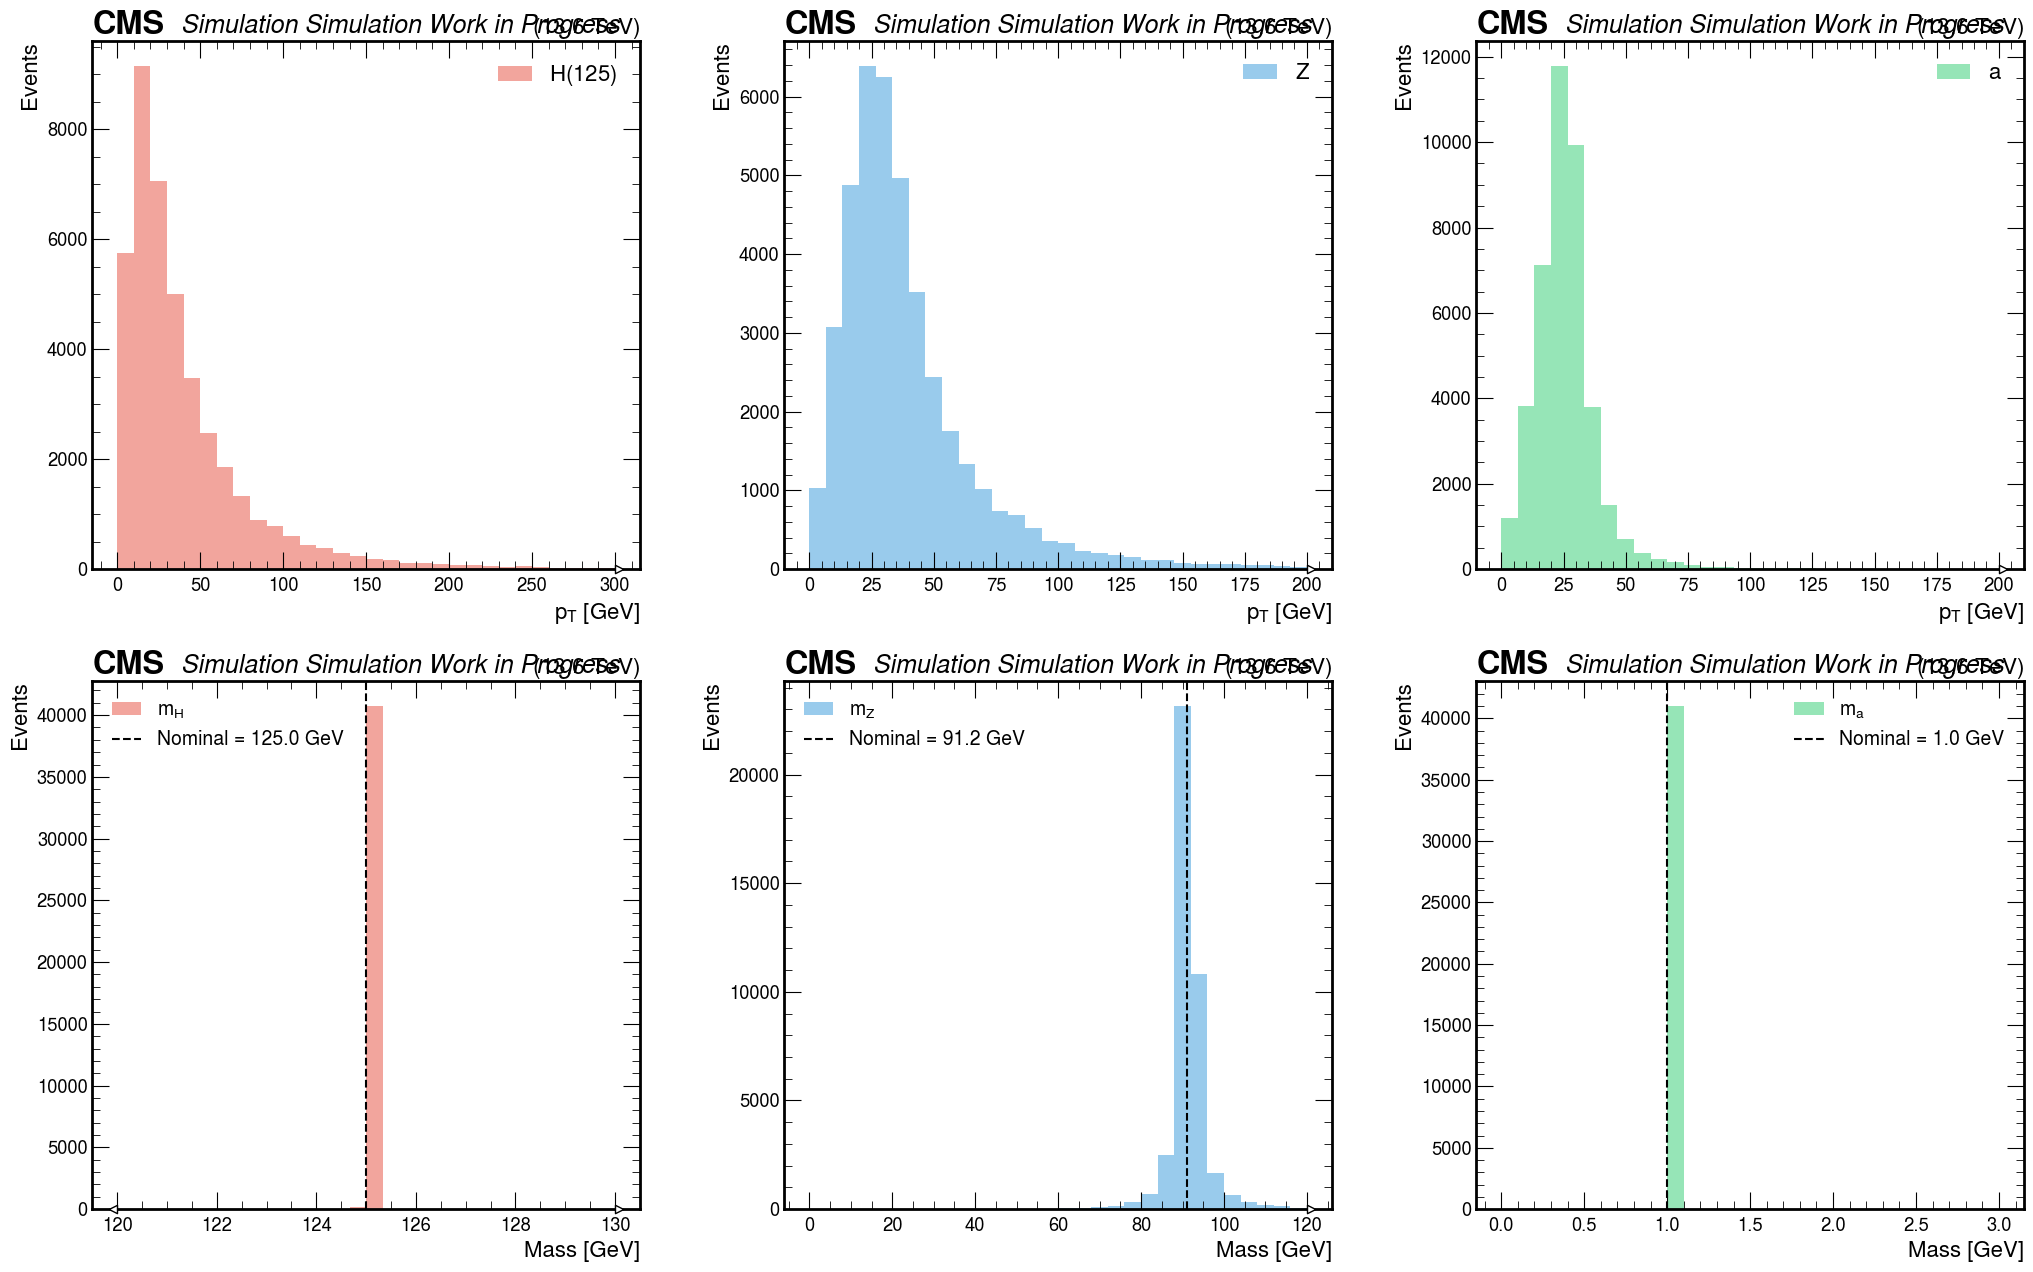

In [9]:
# ── Gen-level plots: Higgs, Z, a ──────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Flatten to 1D numpy arrays for histogramming
h_pt  = ak.flatten(gen_higgs.pt).to_numpy()
z_pt  = ak.flatten(gen_Z.pt).to_numpy()
a_pt  = ak.flatten(gen_a.pt).to_numpy()
h_m   = ak.flatten(gen_higgs.mass).to_numpy()
z_m   = ak.flatten(gen_Z.mass).to_numpy()
a_m   = ak.flatten(gen_a.mass).to_numpy()
h_eta = ak.flatten(gen_higgs.eta).to_numpy()
z_eta = ak.flatten(gen_Z.eta).to_numpy()
a_eta = ak.flatten(gen_a.eta).to_numpy()

# Row 1: pT distributions
for ax, data, label, color, xmax in zip(
    axes[0],
    [h_pt, z_pt, a_pt],
    [r"$H(125)$", r"$Z$", r"$a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
    [300, 200, 200],
):
    h = hist.Hist(hist.axis.Regular(30, 0, xmax, label=r"$p_T$ [GeV]"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.set_ylabel("Events")
    ax.legend(fontsize=16)
    cms_label(ax)

# Row 2: mass distributions
for ax, data, label, color, xrange, vline in zip(
    axes[1],
    [h_m, z_m, a_m],
    [r"$m_H$", r"$m_Z$", r"$m_a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
    [(120, 130), (0, 120), (0, 3)],
    [125.0, 91.2, MASS_A],
):
    h = hist.Hist(hist.axis.Regular(30, *xrange, label="Mass [GeV]"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.axvline(vline, color="black", linestyle="--", linewidth=1.5, label=f"Nominal = {vline} GeV")
    ax.set_ylabel("Events")
    ax.legend(fontsize=14)
    cms_label(ax)

save_and_show(fig, "gen_kinematics.png")

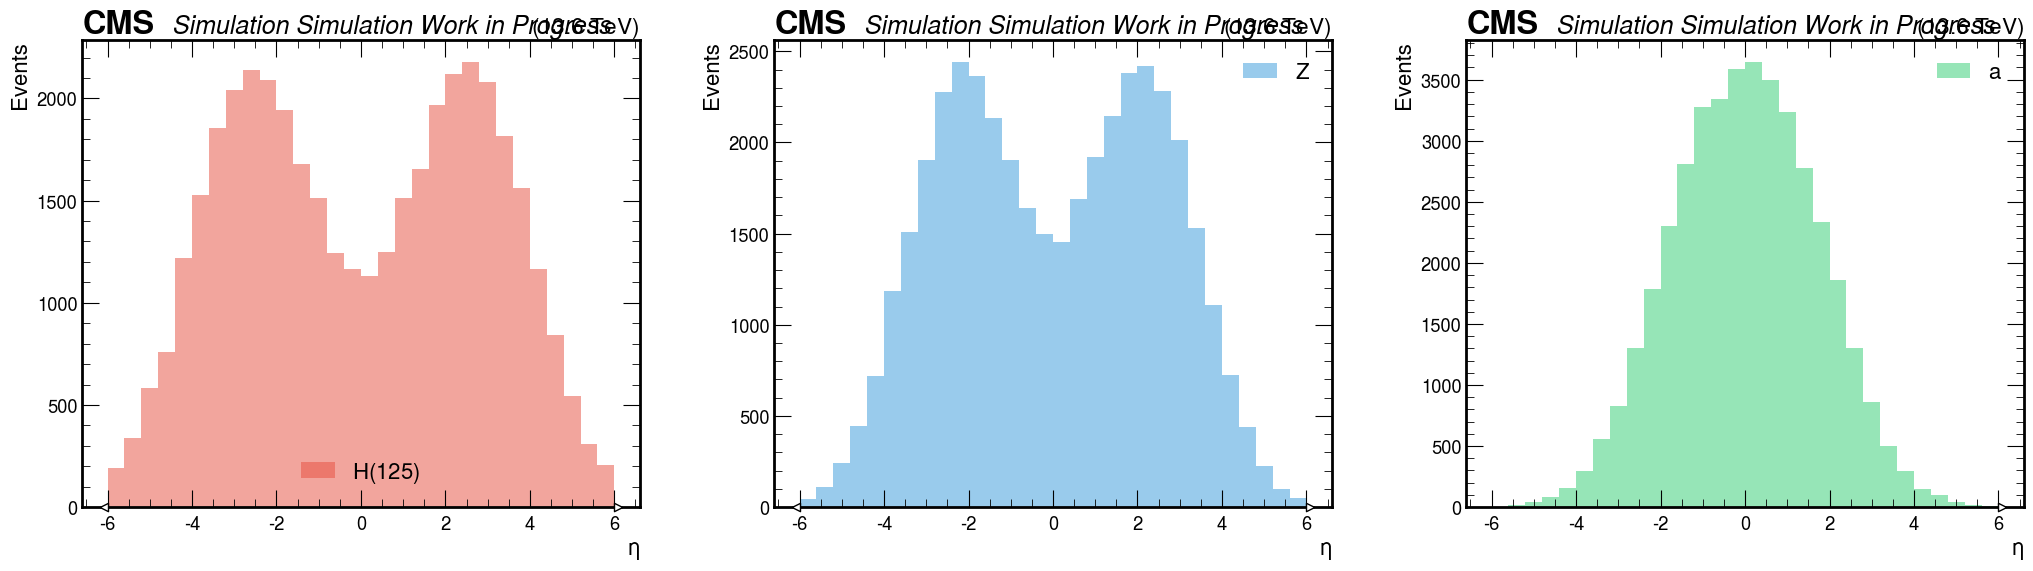

In [10]:
# ── Gen-level angular distributions ───────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, data, label, color in zip(
    axes,
    [h_eta, z_eta, a_eta],
    [r"$H(125)$", r"$Z$", r"$a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
):
    h = hist.Hist(hist.axis.Regular(30, -6, 6, label=r"$\eta$"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.set_ylabel("Events")
    ax.legend(fontsize=16)
    cms_label(ax)

save_and_show(fig, "gen_eta.png")

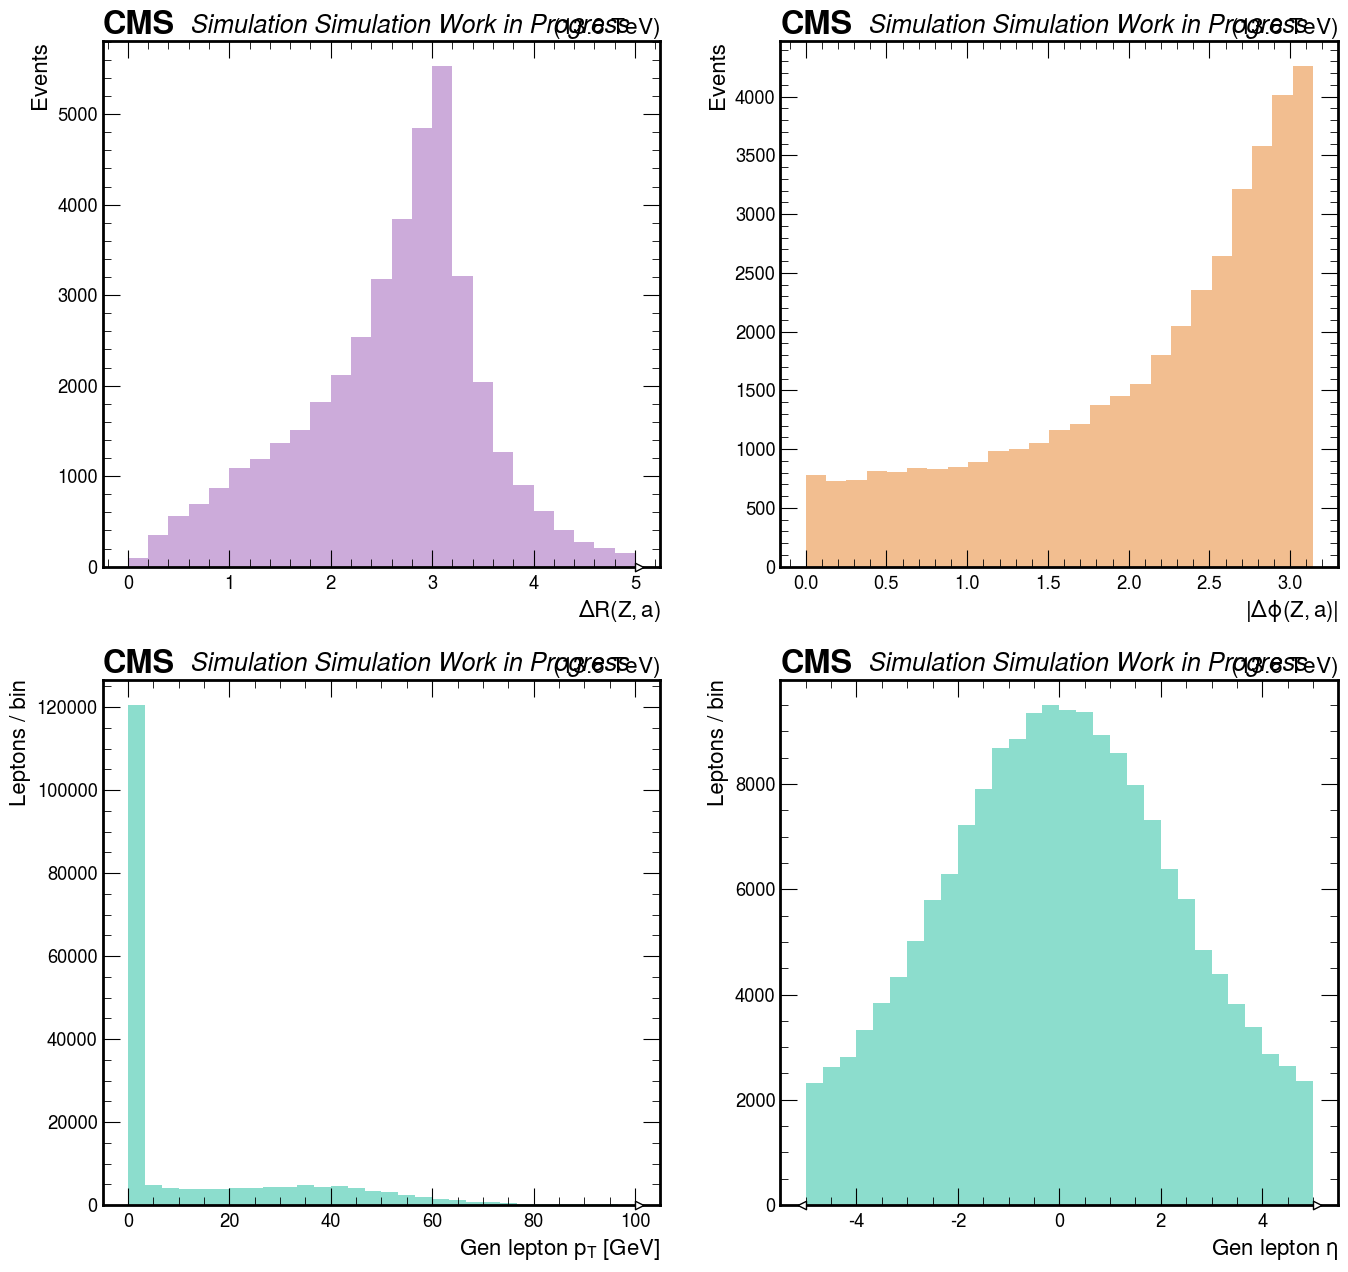

In [11]:
# ── Gen-level ΔR(Z, a) and dilepton mass ─────────────────────────────────────
# Build Lorentz vectors for Z and a (per-event, take first candidate)
gen_Z_vec = vector.zip({
    "pt": gen_Z.pt[:, 0:1], "eta": gen_Z.eta[:, 0:1],
    "phi": gen_Z.phi[:, 0:1], "mass": gen_Z.mass[:, 0:1],
})
gen_a_vec = vector.zip({
    "pt": gen_a.pt[:, 0:1], "eta": gen_a.eta[:, 0:1],
    "phi": gen_a.phi[:, 0:1], "mass": gen_a.mass[:, 0:1],
})

gen_dR_Za = ak.flatten(gen_Z_vec.deltaR(gen_a_vec)).to_numpy()
gen_dphi_Za = ak.flatten(np.abs(gen_Z_vec.deltaphi(gen_a_vec))).to_numpy()

# Gen-level lepton pT and eta (use gen_leptons defined above)
gen_lep_pt  = ak.flatten(gen_leptons.pt).to_numpy()
gen_lep_eta = ak.flatten(gen_leptons.eta).to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 13))

# ΔR(Z, a)
h = hist.Hist(hist.axis.Regular(25, 0, 5, label=r"$\Delta R(Z, a)$"))
h.fill(gen_dR_Za)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[0, 0].set_ylabel("Events")
cms_label(axes[0, 0])

# Δφ(Z, a)
h = hist.Hist(hist.axis.Regular(25, 0, np.pi, label=r"$|\Delta\phi(Z, a)|$"))
h.fill(gen_dphi_Za)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[0, 1].set_ylabel("Events")
cms_label(axes[0, 1])

# Gen lepton pT
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Gen lepton $p_T$ [GeV]"))
h.fill(gen_lep_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[1, 0].set_ylabel("Leptons / bin")
cms_label(axes[1, 0])

# Gen lepton eta
h = hist.Hist(hist.axis.Regular(30, -5, 5, label=r"Gen lepton $\eta$"))
h.fill(gen_lep_eta)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[1, 1].set_ylabel("Leptons / bin")
cms_label(axes[1, 1])

save_and_show(fig, "gen_deltaR_leptons.png")

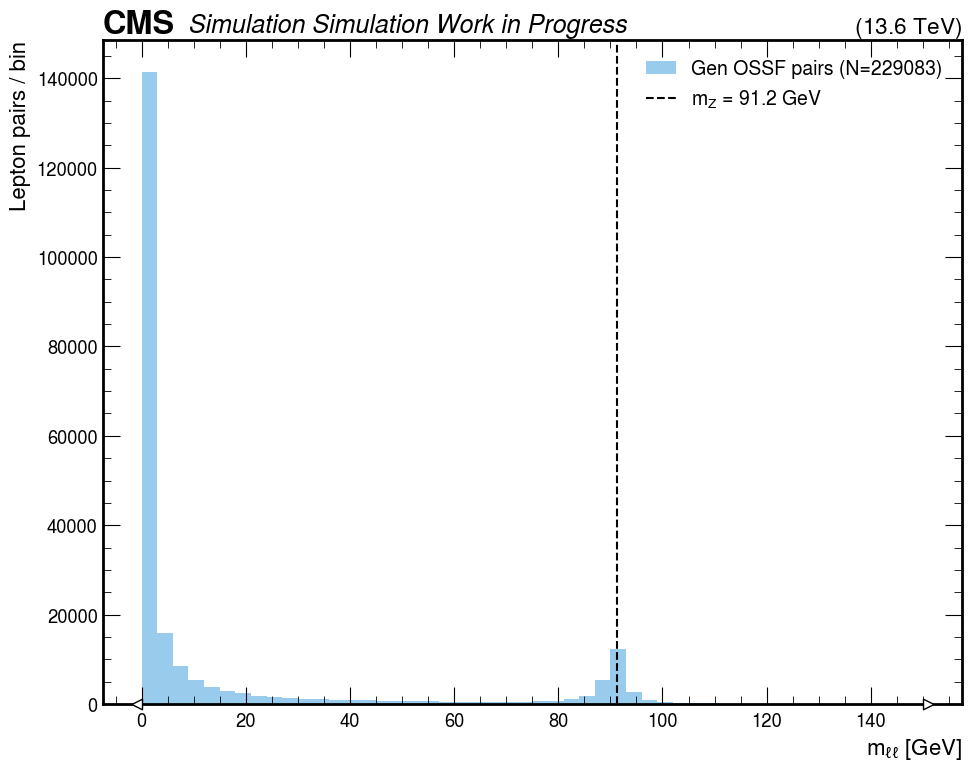

In [12]:
# ── Gen-level dilepton invariant mass (mll) ───────────────────────────────────
# Build Lorentz vectors for gen leptons and compute all OSSF pair masses
gen_lep_vec = vector.zip({
    "pt": gen_leptons.pt, "eta": gen_leptons.eta,
    "phi": gen_leptons.phi, "mass": gen_leptons.mass,
})
gen_lep_pdgId = gen_leptons.pdgId

# All pairs
gen_pairs = ak.argcombinations(gen_lep_vec, 2, axis=1)
gi0, gi1 = ak.unzip(gen_pairs)
gl0 = gen_lep_vec[gi0]
gl1 = gen_lep_vec[gi1]
gq0 = gen_lep_pdgId[gi0]
gq1 = gen_lep_pdgId[gi1]

# Opposite-sign same-flavour
ossf_mask = (gq0 + gq1 == 0)  # e.g. +11 + -11 = 0
gl0_ossf = gl0[ossf_mask]
gl1_ossf = gl1[ossf_mask]
gen_mll = (gl0_ossf + gl1_ossf).mass

gen_mll_flat = ak.flatten(gen_mll).to_numpy()

fig, ax = plt.subplots(figsize=(10, 8))
h = hist.Hist(hist.axis.Regular(50, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h.fill(gen_mll_flat)
hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db",
             label=f"Gen OSSF pairs (N={len(gen_mll_flat)})")
ax.axvline(91.2, color="black", linestyle="--", linewidth=1.5, label=r"$m_Z$ = 91.2 GeV")
ax.set_ylabel("Lepton pairs / bin")
ax.legend(fontsize=14)
cms_label(ax)
save_and_show(fig, "gen_mll.png")

Gen-level a decay modes:
  a → 21, 21: 864 events (86%)
  a → $\mu^+$, $\mu^-$: 135 events (14%)
  a → -1, 1: 1 events (0%)

Gen-level Z decay modes:
  Z → $\mu^+$, $\mu^-$: 345 events (34%)
  Z → $e^+$, $e^-$: 338 events (34%)
  Z → $\tau^+$, $\tau^-$: 317 events (32%)


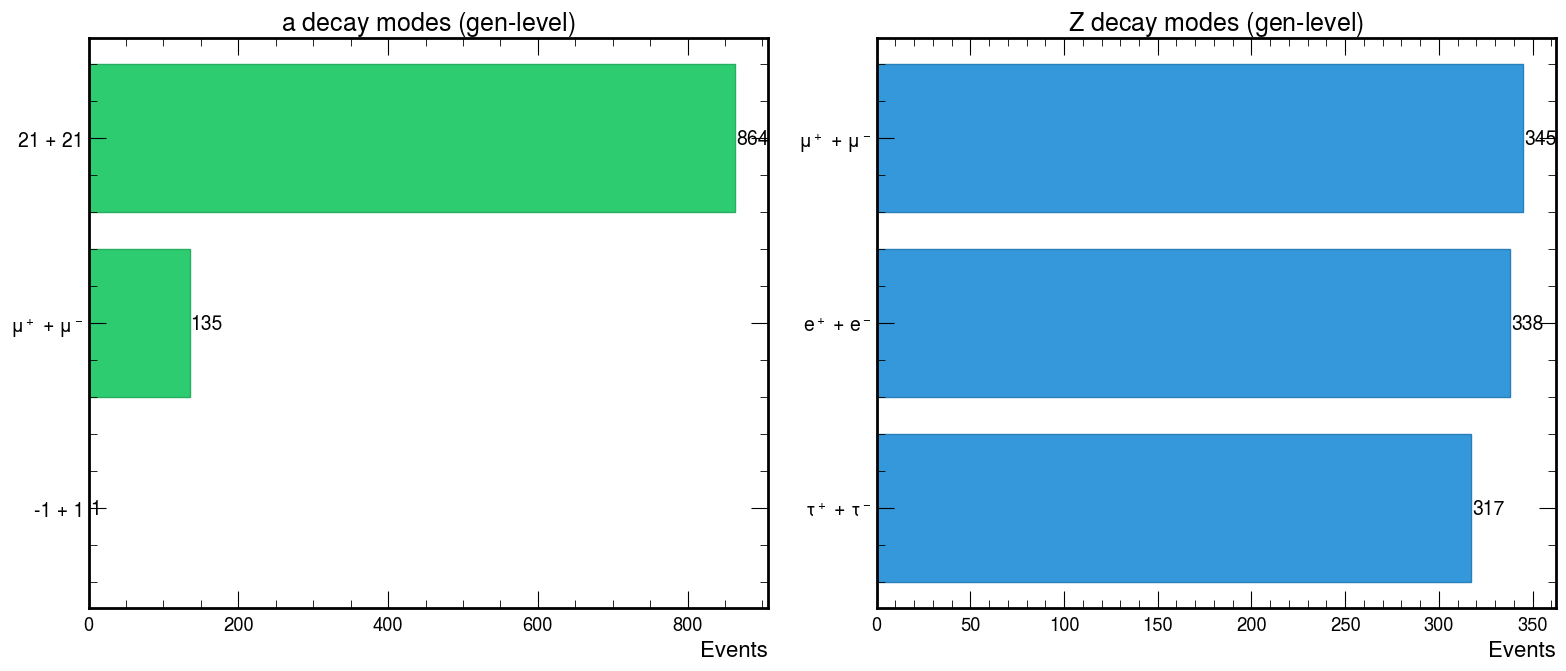

In [16]:
# ── Gen-level a and Z decay products ───────────────────────────────────────────
from collections import Counter

pdg_labels = {
    11: r"$e^-$", -11: r"$e^+$", 13: r"$\mu^-$", -13: r"$\mu^+$",
    15: r"$\tau^-$", -15: r"$\tau^+$", 211: r"$\pi^+$", -211: r"$\pi^-$",
    111: r"$\pi^0$", 22: r"$\gamma$", 321: r"$K^+$", -321: r"$K^-$",
    310: r"$K_S^0$", 130: r"$K_L^0$",
}

def get_decay_modes(events, parent_pdgId, max_events=1_000):
    """Get decay daughter PDG IDs for a given parent particle."""
    modes = Counter()
    daughter_pdgIds = []
    for ievt in range(min(len(events), max_events)):
        pdg = events.GenPart_pdgId[ievt]
        mom = events.GenPart_genPartIdxMother[ievt]
        flags = events.GenPart_statusFlags[ievt]
        for i in range(len(pdg)):
            if abs(pdg[i]) == parent_pdgId and bool(flags[i] & (1 << 13)):
                daughters = tuple(sorted([int(pdg[j]) for j in range(len(pdg)) if mom[j] == i]))
                modes[daughters] += 1
                for d in daughters:
                    daughter_pdgIds.append(abs(d))
    return modes, daughter_pdgIds

a_modes, a_daughter_ids = get_decay_modes(events, 36)
z_modes, z_daughter_ids = get_decay_modes(events, 23)

# Print decay tables
print("Gen-level a decay modes:")
for mode, count in a_modes.most_common():
    names = ", ".join(pdg_labels.get(p, str(p)) for p in mode)
    print(f"  a → {names}: {count} events ({100*count/sum(a_modes.values()):.0f}%)")

print("\nGen-level Z decay modes:")
for mode, count in z_modes.most_common():
    names = ", ".join(pdg_labels.get(p, str(p)) for p in mode)
    print(f"  Z → {names}: {count} events ({100*count/sum(z_modes.values()):.0f}%)")

# ── Plot: a decay daughter PDG IDs ────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# a daughters bar chart by decay mode
a_mode_labels = []
a_mode_counts = []
for mode, count in a_modes.most_common():
    label = " + ".join(pdg_labels.get(p, str(p)) for p in mode)
    a_mode_labels.append(label)
    a_mode_counts.append(count)

axes[0].barh(range(len(a_mode_labels)), a_mode_counts, color="#2ecc71", edgecolor="#27ae60")
axes[0].set_yticks(range(len(a_mode_labels)))
axes[0].set_yticklabels(a_mode_labels, fontsize=14)
axes[0].set_xlabel("Events", fontsize=16)
axes[0].set_title(r"$a$ decay modes (gen-level)", fontsize=18)
axes[0].invert_yaxis()
for i, v in enumerate(a_mode_counts):
    axes[0].text(v + 0.5, i, str(v), va="center", fontsize=14)

# Z daughters bar chart by decay mode
z_mode_labels = []
z_mode_counts = []
for mode, count in z_modes.most_common():
    label = " + ".join(pdg_labels.get(p, str(p)) for p in mode)
    z_mode_labels.append(label)
    z_mode_counts.append(count)

axes[1].barh(range(len(z_mode_labels)), z_mode_counts, color="#3498db", edgecolor="#2980b9")
axes[1].set_yticks(range(len(z_mode_labels)))
axes[1].set_yticklabels(z_mode_labels, fontsize=14)
axes[1].set_xlabel("Events", fontsize=16)
axes[1].set_title(r"$Z$ decay modes (gen-level)", fontsize=18)
axes[1].invert_yaxis()
for i, v in enumerate(z_mode_counts):
    axes[1].text(v + 0.5, i, str(v), va="center", fontsize=14)

save_and_show(fig, "gen_decay_modes.png")

## Reconstructed Object Selection

Apply baseline selection cuts for muons, electrons, and jets following standard CMS Run 3 recommendations.

In [18]:
# ── Muon selection ─────────────────────────────────────────────────────────────
mu_pt_cut  = events.Muon_pt > 5.0          # pT > 5 GeV
mu_eta_cut = np.abs(events.Muon_eta) < 2.4  # |η| < 2.4
mu_id_cut  = events.Muon_mediumId           # Medium ID
mu_iso_cut = events.Muon_pfRelIso04_all < 0.15  # tight isolation

mu_sel = mu_pt_cut & mu_eta_cut & mu_id_cut & mu_iso_cut

# Build muon 4-vectors
sel_mu = vector.zip({
    "pt":   events.Muon_pt[mu_sel],
    "eta":  events.Muon_eta[mu_sel],
    "phi":  events.Muon_phi[mu_sel],
    "mass": events.Muon_mass[mu_sel],
})
sel_mu_charge = events.Muon_charge[mu_sel]

# ── Electron selection ────────────────────────────────────────────────────────
el_pt_cut  = events.Electron_pt > 7.0           # pT > 7 GeV
el_eta_cut = np.abs(events.Electron_eta) < 2.5  # |η| < 2.5
el_id_cut  = events.Electron_cutBased >= 3       # Medium cut-based ID and isolation

el_sel = el_pt_cut & el_eta_cut & el_id_cut

sel_el = vector.zip({
    "pt":   events.Electron_pt[el_sel],
    "eta":  events.Electron_eta[el_sel],
    "phi":  events.Electron_phi[el_sel],
    "mass": events.Electron_mass[el_sel],
})
sel_el_charge = events.Electron_charge[el_sel]

# ── Jet selection ─────────────────────────────────────────────────────────────
jet_pt_cut  = events.Jet_pt > 25.0           # pT > 25 GeV
jet_eta_cut = np.abs(events.Jet_eta) < 2.5   # |η| < 2.5

jet_sel = jet_pt_cut & jet_eta_cut

sel_jets = vector.zip({
    "pt":   events.Jet_pt[jet_sel],
    "eta":  events.Jet_eta[jet_sel],
    "phi":  events.Jet_phi[jet_sel],
    "mass": events.Jet_mass[jet_sel],
})
sel_jet_btag = events.Jet_btagDeepFlavB[jet_sel]

# Summary
n_mu  = ak.num(sel_mu)
n_el  = ak.num(sel_el)
n_jet = ak.num(sel_jets)

print(f"Selected muons:     mean {ak.mean(n_mu):.2f}/event,  total {ak.sum(n_mu)}")
print(f"Selected electrons: mean {ak.mean(n_el):.2f}/event,  total {ak.sum(n_el)}")
print(f"Selected jets:      mean {ak.mean(n_jet):.2f}/event, total {ak.sum(n_jet)}")

Selected muons:     mean 0.70/event,  total 28530
Selected electrons: mean 0.51/event,  total 20858
Selected jets:      mean 2.38/event, total 97659


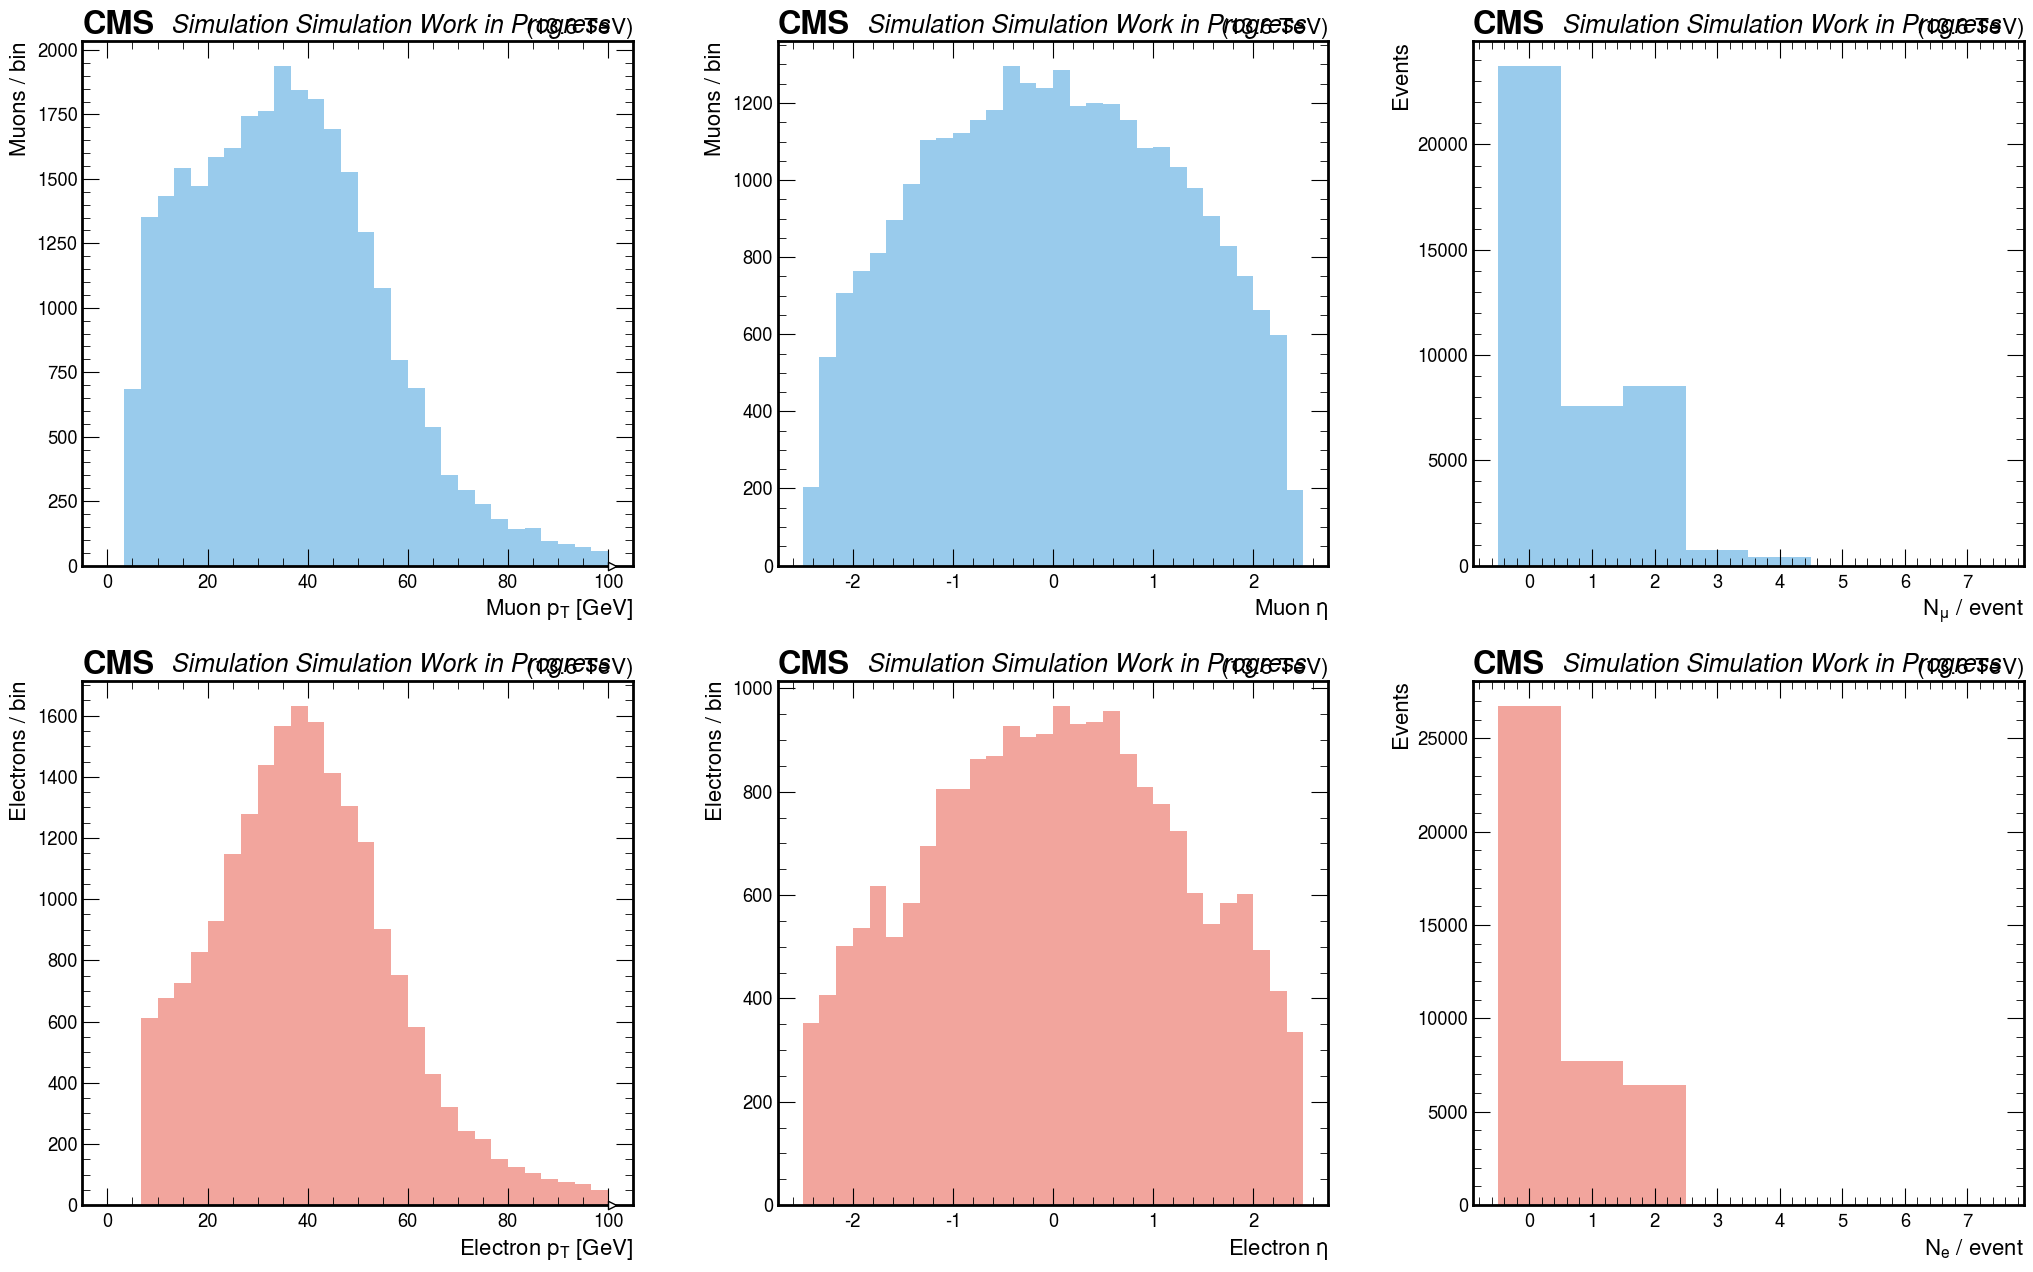

In [19]:
# ── Reco lepton kinematic plots ────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Muon pT
all_mu_pt = ak.flatten(sel_mu.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Muon $p_T$ [GeV]"))
h.fill(all_mu_pt)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 0].set_ylabel("Muons / bin")
cms_label(axes[0, 0])

# Muon eta
all_mu_eta = ak.flatten(sel_mu.eta).to_numpy()
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Muon $\eta$"))
h.fill(all_mu_eta)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 1].set_ylabel("Muons / bin")
cms_label(axes[0, 1])

# Muon multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\mu}$ / event"))
h.fill(ak.to_numpy(n_mu))
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 2].set_ylabel("Events")
cms_label(axes[0, 2])

# Electron pT
all_el_pt = ak.flatten(sel_el.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Electron $p_T$ [GeV]"))
h.fill(all_el_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 0].set_ylabel("Electrons / bin")
cms_label(axes[1, 0])

# Electron eta
all_el_eta = ak.flatten(sel_el.eta).to_numpy()
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Electron $\eta$"))
h.fill(all_el_eta)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 1].set_ylabel("Electrons / bin")
cms_label(axes[1, 1])

# Electron multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{e}$ / event"))
h.fill(ak.to_numpy(n_el))
hep.histplot(h, ax=axes[1, 2], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 2].set_ylabel("Events")
cms_label(axes[1, 2])

save_and_show(fig, "reco_lepton_kinematics.png")

## Z Boson Reconstruction

Reconstruct Z → ℓ⁺ℓ⁻ candidates from opposite-sign same-flavour (OSSF) lepton pairs. For events with multiple candidates, select the pair whose invariant mass is closest to $m_Z = 91.2$ GeV.

In [21]:
# ── Z → μ⁺μ⁻ reconstruction ───────────────────────────────────────────────────
def reconstruct_z(leptons, charges, mz=91.2):
    """
    Reconstruct Z → ℓℓ from OSSF pairs, selecting the pair closest to mZ.
    Returns per-event Z candidate 4-vector (None-padded for events without a candidate).
    """
    # Build all pairs of indices
    n_lep = ak.num(leptons)
    idx = ak.local_index(leptons)
    pairs = ak.argcombinations(leptons, 2, axis=1)
    i0, i1 = ak.unzip(pairs)

    lep0 = leptons[i0]
    lep1 = leptons[i1]
    q0   = charges[i0]
    q1   = charges[i1]

    # Opposite-sign requirement
    os_mask = (q0 * q1 < 0)
    lep0 = lep0[os_mask]
    lep1 = lep1[os_mask]

    # Compute dilepton invariant mass
    z_cand = lep0 + lep1
    z_mass = z_cand.mass

    # Select pair closest to mZ
    dm = np.abs(z_mass - mz)
    best_idx = ak.argmin(dm, axis=1, keepdims=True)

    z_best = z_cand[best_idx]
    return z_best

# Reconstruct Z from muons
z_from_mu = reconstruct_z(sel_mu, sel_mu_charge)

# Reconstruct Z from electrons
z_from_el = reconstruct_z(sel_el, sel_el_charge)

# Combine: prefer the channel with mass closer to mZ
# Flatten to compare (pad with None for events without candidate)
z_mu_mass = ak.fill_none(ak.firsts(z_from_mu.mass), -999.0)
z_el_mass = ak.fill_none(ak.firsts(z_from_el.mass), -999.0)

prefer_mu = np.abs(z_mu_mass - 91.2) <= np.abs(z_el_mass - 91.2)
# If neither channel has a candidate, skip
has_z_mu = z_mu_mass > 0
has_z_el = z_el_mass > 0
has_z    = has_z_mu | has_z_el

# Build final Z candidate arrays
z_pt   = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.pt), 0.0),   ak.fill_none(ak.firsts(z_from_el.pt), 0.0))
z_eta  = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.eta), 0.0),  ak.fill_none(ak.firsts(z_from_el.eta), 0.0))
z_phi  = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.phi), 0.0),  ak.fill_none(ak.firsts(z_from_el.phi), 0.0))
z_mass = ak.where(prefer_mu, z_mu_mass, z_el_mass)
z_channel = ak.where(prefer_mu & has_z_mu, 1, ak.where(has_z_el, 2, 0))  # 1=μμ, 2=ee, 0=none

n_z = ak.sum(has_z)
n_z_mm = ak.sum(z_channel == 1)
n_z_ee = ak.sum(z_channel == 2)
print(f"Z candidates found: {n_z} total ({n_z_mm} μμ, {n_z_ee} ee)")
print(f"Events without Z:   {ak.sum(~has_z)}")

Z candidates found: 15641 total (9217 μμ, 6424 ee)
Events without Z:   25359


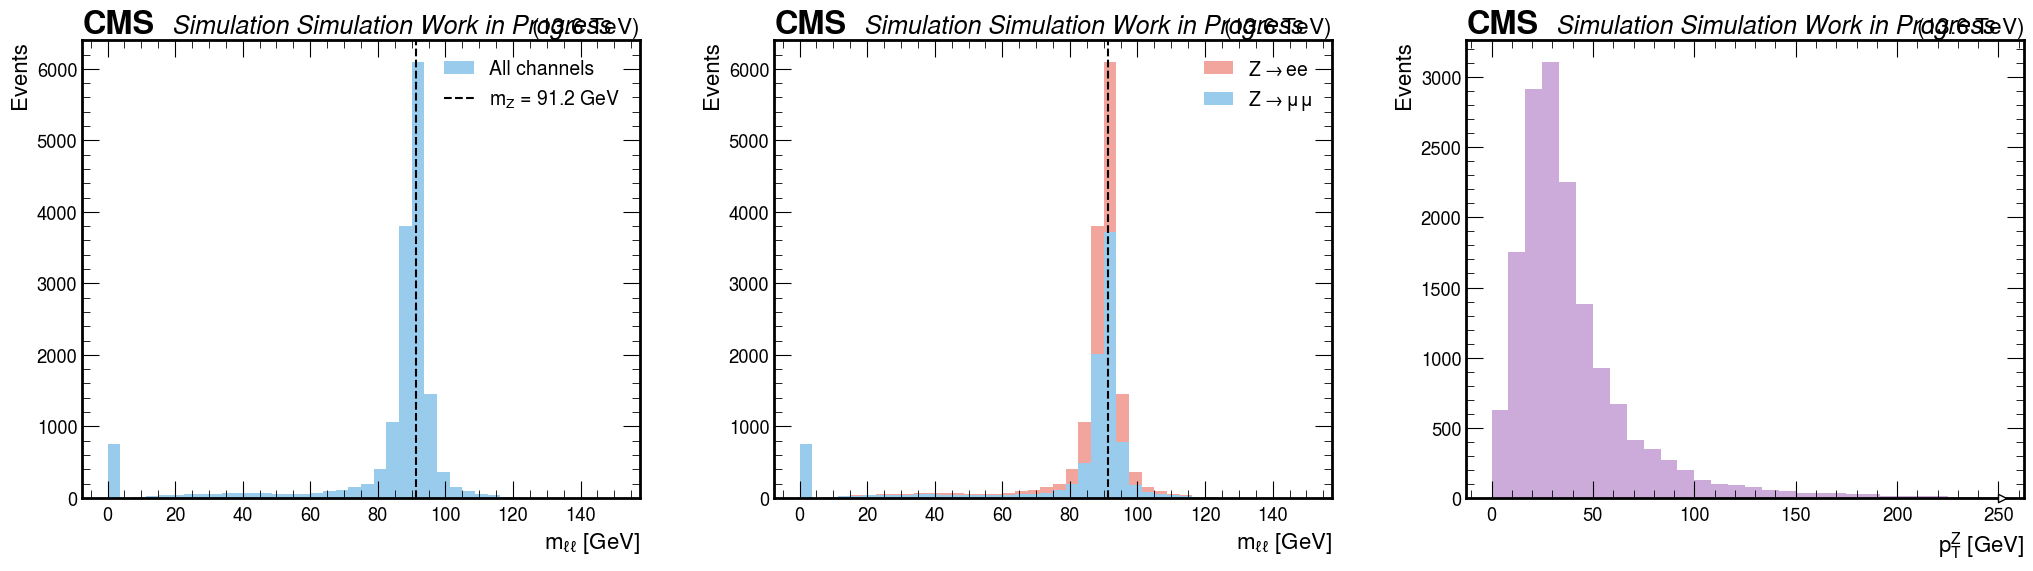

In [22]:
# ── Z candidate plots ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Z mass (all channels)
z_mass_arr = ak.to_numpy(z_mass[has_z])
h = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h.fill(z_mass_arr)
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db",
             label="All channels")
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1.5, label=r"$m_Z$ = 91.2 GeV")
axes[0].set_ylabel("Events")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# Z mass by channel
z_mass_mm = ak.to_numpy(z_mass[z_channel == 1])
z_mass_ee = ak.to_numpy(z_mass[z_channel == 2])
h_mm = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_ee = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_mm.fill(z_mass_mm)
h_ee.fill(z_mass_ee)
hep.histplot([h_mm, h_ee], ax=axes[1], histtype="fill", alpha=0.5,
             label=[r"$Z \to \mu\mu$", r"$Z \to ee$"],
             color=["#3498db", "#e74c3c"], edgecolor=["#3498db", "#e74c3c"], stack=True)
axes[1].axvline(91.2, color="black", linestyle="--", linewidth=1.5)
axes[1].set_ylabel("Events")
axes[1].legend(fontsize=14)
cms_label(axes[1])

# Z pT
z_pt_arr = ak.to_numpy(z_pt[has_z])
h = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h.fill(z_pt_arr)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "reco_z_candidate.png")

## Pseudoscalar $a$ Decay and Reconstruction

First we inspect the gen-level $a$ decay products, then attempt to reconstruct $a$ candidates from the `IsoTrack` collection in NanoAOD.

**Reconstruction strategy (IsoTracks):**
1. Select high-purity isolated tracks not overlapping with the Z lepton candidates ($\Delta R > 0.3$)
2. Assign pion mass to each track and combine all opposite-sign pairs
3. Select the pair closest to $m_a$ as the $a$ candidate
4. Combine with the Z candidate to reconstruct $H \to Za$

In [26]:
# ── Reconstruct a → tracks using IsoTracks ─────────────────────────────────────
# Build IsoTrack 4-vectors with pion mass hypothesis
M_PION = 0.13957  # GeV

# IsoTrack quality selection
trk_pt   = events["IsoTrack_pt"]
trk_eta  = events["IsoTrack_eta"]
trk_phi  = events["IsoTrack_phi"]
trk_q    = events["IsoTrack_charge"]
trk_iso  = events["IsoTrack_pfRelIso03_all"]
trk_pv   = events["IsoTrack_fromPV"]
trk_hp   = events["IsoTrack_isHighPurityTrack"]
trk_dxy  = events["IsoTrack_dxy"]
trk_dz   = events["IsoTrack_dz"]
trk_pdgId = events["IsoTrack_pdgId"]

trk_sel = (
    (trk_pt > 0.5)
    & (np.abs(trk_eta) < 2.5)
    & (trk_pv >= 1) # fromPV = 1 loose, 2 tight
    & (trk_hp == 1)
    & (np.abs(trk_dxy) < 0.1)
    & (np.abs(trk_dz) < 0.5)
)

# Build 4-vectors for selected tracks
sel_trk_pt  = trk_pt[trk_sel]
sel_trk_eta = trk_eta[trk_sel]
sel_trk_phi = trk_phi[trk_sel]
sel_trk_q   = trk_q[trk_sel]
sel_trk_pdgId = trk_pdgId[trk_sel]

sel_tracks = vector.zip({
    "pt":   sel_trk_pt,
    "eta":  sel_trk_eta,
    "phi":  sel_trk_phi,
    "mass": M_PION * ak.ones_like(sel_trk_pt),
})

n_trk = ak.num(sel_tracks)
print(f"IsoTrack selection: {int(ak.sum(n_trk))} tracks pass quality cuts")
print(f"Events with ≥2 tracks: {int(ak.sum(n_trk >= 2))}")
print(f"Events with ≥1 track:  {int(ak.sum(n_trk >= 1))}")
print(f"Events with 0 tracks:  {int(ak.sum(n_trk == 0))}")

# Lepton overlap removal: remove tracks within ΔR < 0.3 of selected muons or electrons
# Build lepton list for overlap removal
def remove_overlap(tracks, leptons, dr_cut=0.3):
    """Remove tracks overlapping with any lepton within dr_cut."""
    if ak.sum(ak.num(leptons)) == 0:
        return ak.ones_like(tracks.pt, dtype=bool)
    # Cross-product: for each track, check distance to all leptons
    trk_eta_bc, lep_eta_bc = ak.unzip(ak.cartesian([tracks.eta, leptons.eta], axis=1, nested=True))
    trk_phi_bc, lep_phi_bc = ak.unzip(ak.cartesian([tracks.phi, leptons.phi], axis=1, nested=True))
    deta = trk_eta_bc - lep_eta_bc
    dphi = np.mod(trk_phi_bc - lep_phi_bc + np.pi, 2 * np.pi) - np.pi
    dr = np.sqrt(deta**2 + dphi**2)
    min_dr = ak.min(dr, axis=-1)
    return min_dr > dr_cut

not_mu_overlap = remove_overlap(sel_tracks, sel_mu)
not_el_overlap = remove_overlap(sel_tracks, sel_el)
no_overlap = not_mu_overlap & not_el_overlap

clean_tracks = sel_tracks[no_overlap]
clean_q = sel_trk_q[no_overlap]
clean_pdgId = sel_trk_pdgId[no_overlap]
n_clean_trk = ak.num(clean_tracks)

print(f"\nAfter lepton overlap removal:")
print(f"  Tracks remaining: {int(ak.sum(n_clean_trk))}")
print(f"  Events with ≥2 tracks: {int(ak.sum(n_clean_trk >= 2))}")

# Form opposite-sign track pairs → a candidates
pairs = ak.argcombinations(clean_tracks, 2, axis=1)
if ak.sum(ak.num(pairs)) > 0:
    i0, i1 = ak.unzip(pairs)
    t0 = clean_tracks[i0]
    t1 = clean_tracks[i1]
    q0 = clean_q[i0]
    q1 = clean_q[i1]

    os_mask = (q0 * q1 < 0)
    t0_os = t0[os_mask]
    t1_os = t1[os_mask]
    trk_pair_sum = t0_os + t1_os
    trk_pair_mass = trk_pair_sum.mass

    # Best a candidate: OS pair closest to MASS_A
    dm_a = np.abs(trk_pair_mass - MASS_A)
    best_idx = ak.argmin(dm_a, axis=1, keepdims=True)
    a_best = trk_pair_sum[best_idx]

    has_a_cand = (ak.num(trk_pair_mass) > 0)
    a_cand_mass = ak.fill_none(ak.firsts(a_best.mass), -999)
    a_cand_pt   = ak.fill_none(ak.firsts(a_best.pt), -999)
    a_cand_eta  = ak.fill_none(ak.firsts(a_best.eta), -999)
    a_cand_phi  = ak.fill_none(ak.firsts(a_best.phi), -999)
else:
    has_a_cand = ak.zeros_like(n_trk, dtype=bool)
    a_cand_mass = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_pt   = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_eta  = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_phi  = -999 * ak.ones_like(n_trk, dtype=float)
    trk_pair_mass = ak.Array([[] for _ in range(len(events))])

has_a_reco = has_a_cand & (a_cand_mass > 0)
print(f"\na candidates from OS track pairs: {int(ak.sum(has_a_reco))}")
print(f"Events without a candidate: {int(ak.sum(~has_a_reco))}")
print(f"\nNote: IsoTrack collection is sparse — low reconstruction efficiency is expected.")

IsoTrack selection: 12680 tracks pass quality cuts
Events with ≥2 tracks: 1463
Events with ≥1 track:  11110
Events with 0 tracks:  29890

After lepton overlap removal:
  Tracks remaining: 12617
  Events with ≥2 tracks: 1460

a candidates from OS track pairs: 3
Events without a candidate: 40997

Note: IsoTrack collection is sparse — low reconstruction efficiency is expected.


/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


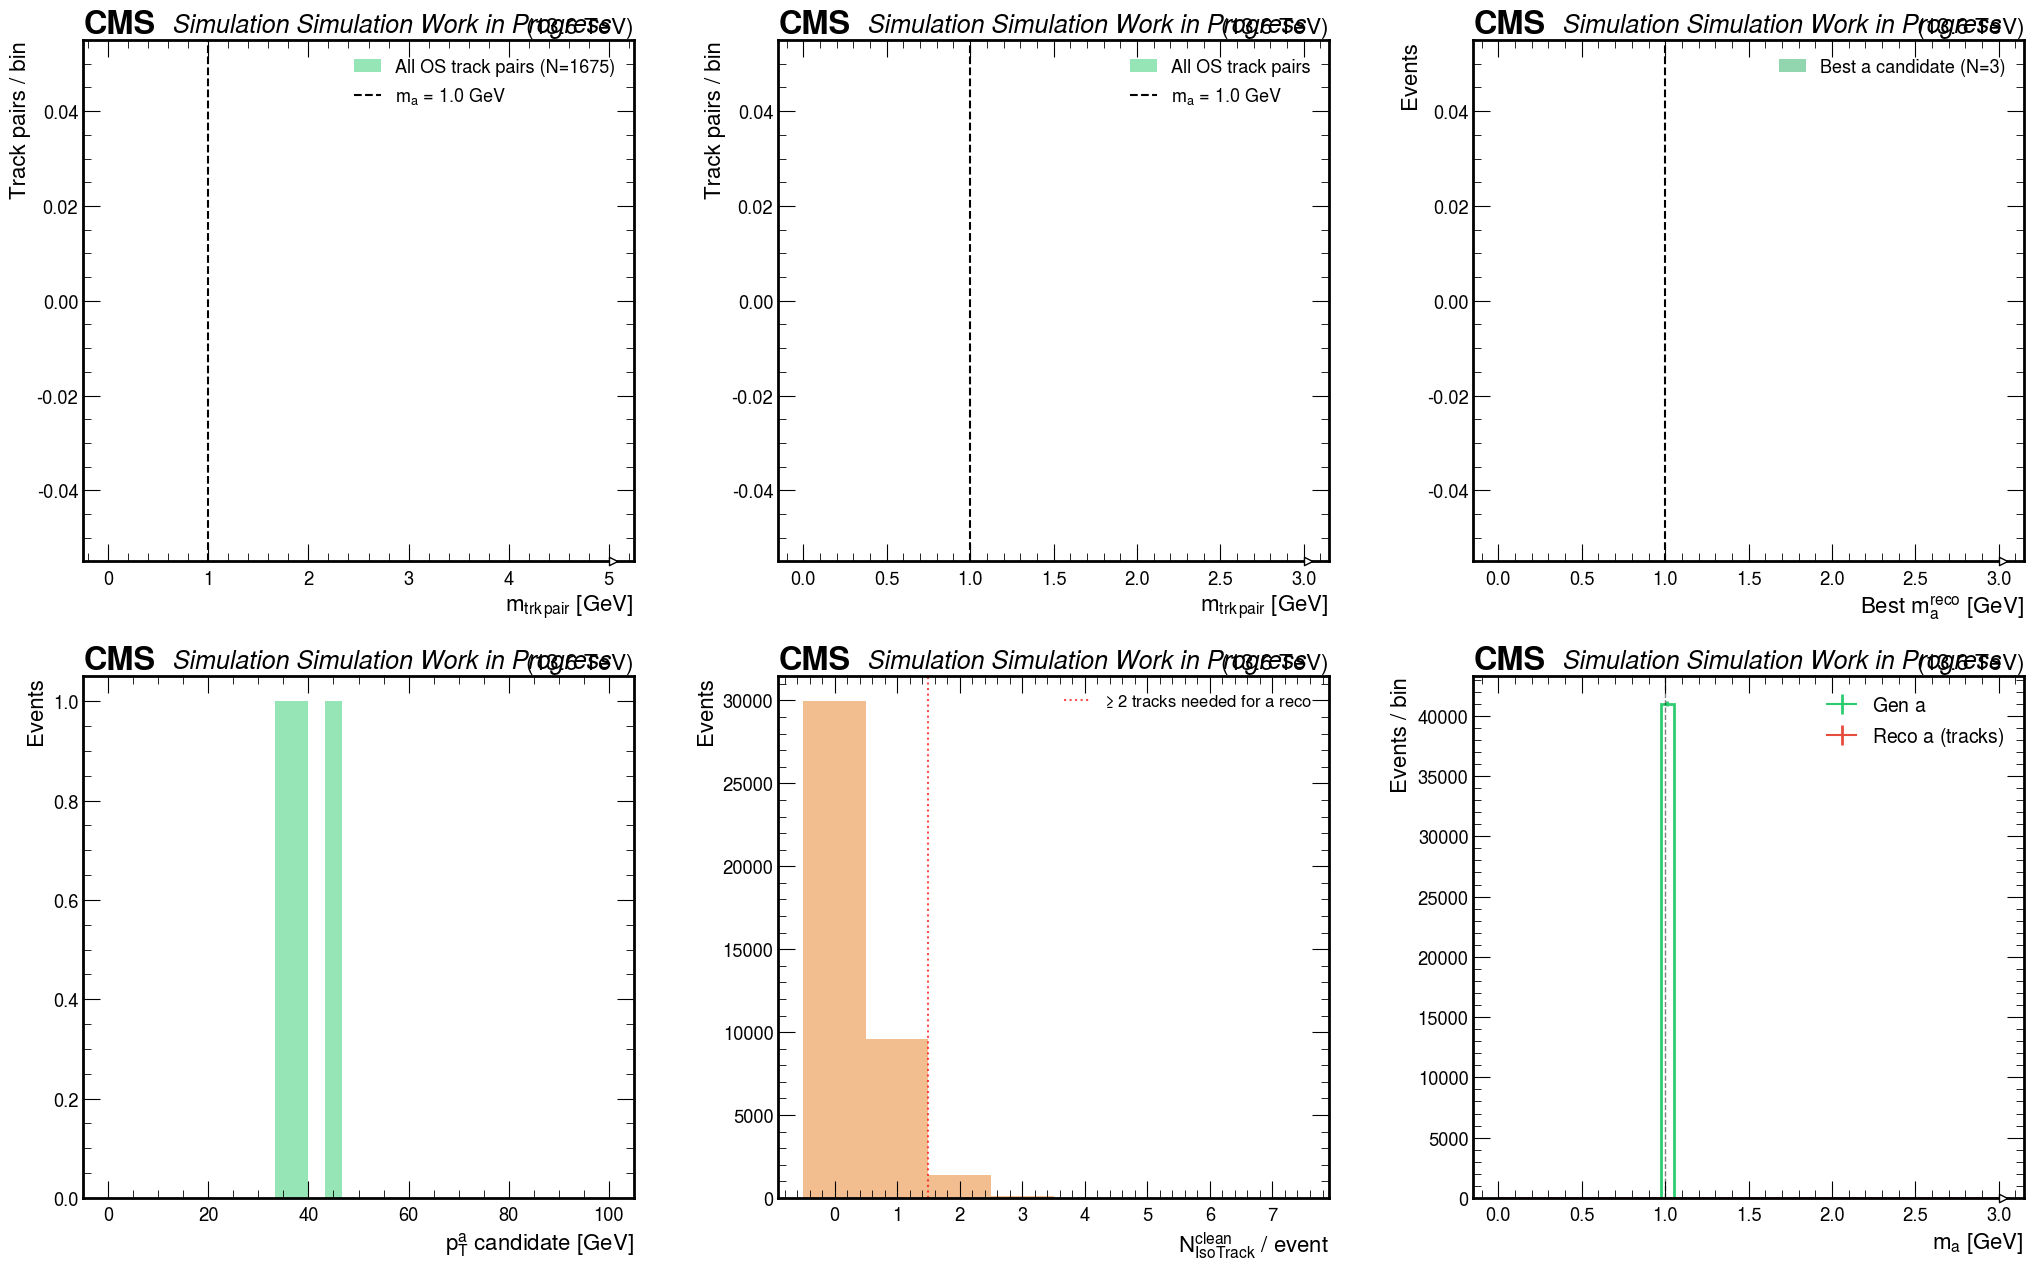

In [27]:
# ── a → track pair candidate plots ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

a_reco_m_arr = ak.to_numpy(a_cand_mass[has_a_reco]) if int(ak.sum(has_a_reco)) > 0 else np.array([])
a_reco_pt_arr = ak.to_numpy(a_cand_pt[has_a_reco]) if int(ak.sum(has_a_reco)) > 0 else np.array([])

# All OS track pair invariant mass
all_trk_pair_m = ak.flatten(trk_pair_mass)
if len(all_trk_pair_m) > 0:
    all_trk_pair_m = all_trk_pair_m.to_numpy()
else:
    all_trk_pair_m = np.array([])

h = hist.Hist(hist.axis.Regular(50, 0, 5, label=r"$m_{\mathrm{trk\,pair}}$ [GeV]"))
if len(all_trk_pair_m) > 0:
    h.fill(all_trk_pair_m)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71",
             label=f"All OS track pairs (N={len(all_trk_pair_m)})")
axes[0, 0].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5,
                   label=f"$m_a$ = {MASS_A} GeV")
axes[0, 0].set_ylabel("Track pairs / bin")
axes[0, 0].legend(fontsize=13)
cms_label(axes[0, 0])

# Zoom near m_a
h = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"$m_{\mathrm{trk\,pair}}$ [GeV]"))
if len(all_trk_pair_m) > 0:
    h.fill(all_trk_pair_m)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71",
             label="All OS track pairs")
axes[0, 1].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5,
                   label=f"$m_a$ = {MASS_A} GeV")
axes[0, 1].set_ylabel("Track pairs / bin")
axes[0, 1].legend(fontsize=13)
cms_label(axes[0, 1])

# Best a candidate mass per event
h = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"Best $m_a^{\mathrm{reco}}$ [GeV]"))
if len(a_reco_m_arr) > 0:
    h.fill(a_reco_m_arr)
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#27ae60", edgecolor="#27ae60",
             label=f"Best a candidate (N={len(a_reco_m_arr)})")
axes[0, 2].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5)
axes[0, 2].set_ylabel("Events")
axes[0, 2].legend(fontsize=13)
cms_label(axes[0, 2])

# a candidate pT
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"$p_T^{a}$ candidate [GeV]"))
if len(a_reco_pt_arr) > 0:
    h.fill(a_reco_pt_arr)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[1, 0].set_ylabel("Events")
cms_label(axes[1, 0])

# IsoTrack multiplicity (after cleaning)
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\mathrm{IsoTrack}}^{\mathrm{clean}}$ / event"))
h.fill(ak.to_numpy(n_clean_trk))
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[1, 1].set_ylabel("Events")
axes[1, 1].axvline(1.5, color="red", linestyle=":", linewidth=1.5, alpha=0.7,
                   label=r"$\geq 2$ tracks needed for $a$ reco")
axes[1, 1].legend(fontsize=12)
cms_label(axes[1, 1])

# Gen vs reco a mass comparison
h_gen_a = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"$m_a$ [GeV]"))
h_reco_a = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"$m_a$ [GeV]"))
h_gen_a.fill(a_m)
if len(a_reco_m_arr) > 0:
    h_reco_a.fill(a_reco_m_arr)
hep.histplot(h_gen_a, ax=axes[1, 2], histtype="step", linewidth=2, color="#2ecc71", label="Gen $a$")
hep.histplot(h_reco_a, ax=axes[1, 2], histtype="step", linewidth=2, color="#e74c3c",
             label=r"Reco $a$ (tracks)")
axes[1, 2].axvline(MASS_A, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[1, 2].set_ylabel("Events / bin")
axes[1, 2].legend(fontsize=14)
cms_label(axes[1, 2])

save_and_show(fig, "reco_a_candidate.png")

Events with both Z and a candidates: 2


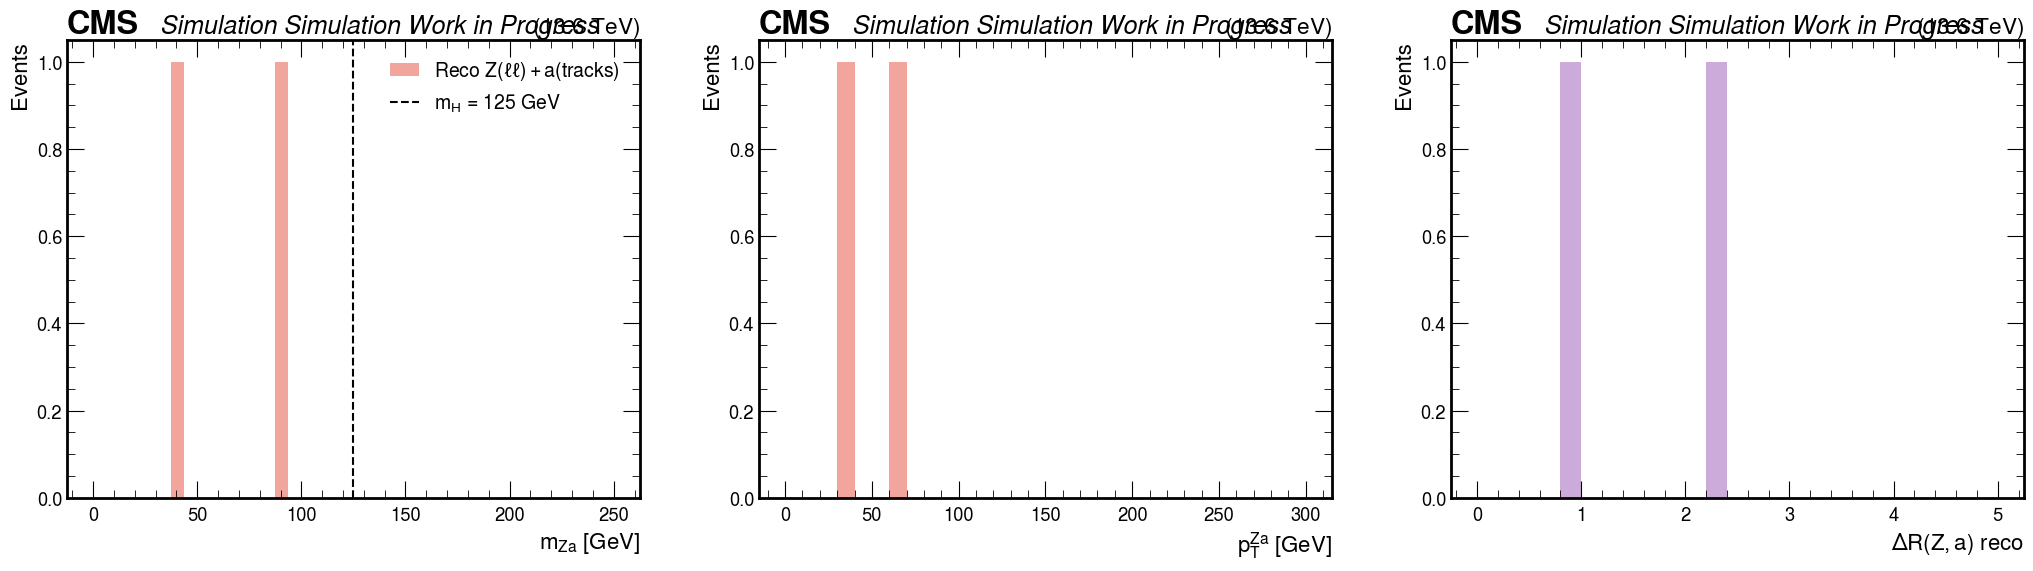

In [28]:
# ── Higgs → Za reconstruction ──────────────────────────────────────────────────
# Combine reco Z candidate (from ℓℓ) + reco a candidate (from IsoTracks)
has_both = has_z & has_a_reco

z_vec_for_h = vector.zip({
    "pt":   z_pt[has_both],
    "eta":  z_eta[has_both],
    "phi":  z_phi[has_both],
    "mass": z_mass[has_both],
})
a_vec_for_h = vector.zip({
    "pt":   a_cand_pt[has_both],
    "eta":  a_cand_eta[has_both],
    "phi":  a_cand_phi[has_both],
    "mass": a_cand_mass[has_both],
})

h_cand = z_vec_for_h + a_vec_for_h

print(f"Events with both Z and a candidates: {int(ak.sum(has_both))}")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

if int(ak.sum(has_both)) > 0:
    h_cand_m = ak.to_numpy(h_cand.mass)
    h_cand_pt = ak.to_numpy(h_cand.pt)
    dr_za_reco = ak.to_numpy(z_vec_for_h.deltaR(a_vec_for_h))
else:
    h_cand_m = np.array([])
    h_cand_pt = np.array([])
    dr_za_reco = np.array([])

# H candidate mass
h = hist.Hist(hist.axis.Regular(40, 0, 250, label=r"$m_{Za}$ [GeV]"))
if len(h_cand_m) > 0:
    h.fill(h_cand_m)
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c",
             label=r"Reco $Z(\ell\ell) + a(\mathrm{tracks})$")
axes[0].axvline(125.0, color="black", linestyle="--", linewidth=1.5, label=r"$m_H$ = 125 GeV")
axes[0].set_ylabel("Events")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# H candidate pT
h = hist.Hist(hist.axis.Regular(30, 0, 300, label=r"$p_T^{Za}$ [GeV]"))
if len(h_cand_pt) > 0:
    h.fill(h_cand_pt)
hep.histplot(h, ax=axes[1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1].set_ylabel("Events")
cms_label(axes[1])

# ΔR(Z, a) reco
h = hist.Hist(hist.axis.Regular(25, 0, 5, label=r"$\Delta R(Z, a)$ reco"))
if len(dr_za_reco) > 0:
    h.fill(dr_za_reco)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "reco_higgs_candidate.png")

## Pseudoscalar $a$ Reconstruction from PF Candidates

The `IsoTrack` collection in NanoAOD is sparse by design (only isolated tracks are stored).
For a low-mass pseudoscalar $a \to gg / q\bar{q}$, the decay products are soft and may
not pass isolation requirements.

Here we use the **PFCands** (particle flow candidates) collection, which stores *all*
charged PF candidates from the primary vertex. This gives much higher track multiplicity
and better sensitivity to soft, collimated $a$ decays.

**Four reconstruction strategies** are compared:

| Method | Description | Applicable to data? |
|--------|-------------|---------------------|
| **Jet-based cone sum** | Sum all PFCands within $\Delta R < 0.4$ of the leading clean jet axis. Captures multi-hadron $a \to gg$ decays. | ✅ Yes |
| **Collimated OS pairs** | Opposite-sign PFCand pairs with $\Delta R(\mathrm{trk}_1, \mathrm{trk}_2) < 0.4$. Reduces combinatorial background. | ✅ Yes |
| **All OS pairs** (baseline) | All opposite-sign PFCand pairs, pick closest to $m_a$. | ⚠️ Biased by construction |
| **Gen-matched cone sum** | Sum PFCands within $\Delta R < 0.4$ of the gen-level $a$ direction. | ❌ MC only (validation) |

The **jet-based cone sum** is the primary data-driven strategy for $a \to gg$: at $m_a \sim 1\text{ GeV}$, the gluons are extremely collimated ($\Delta R \sim 2 m_a / p_T \sim 0.03$) and appear as a single jet. The gen-matched cone serves as a best-case validation reference.

In [29]:
# ── Reconstruct a → tracks using PF Candidates ───────────────────
# PFCands are loaded separately from the core events to avoid holding everything
# in memory at once. The OS-pair computation is chunked to prevent the O(N²)
# pair explosion.

_n = len(events)

if not HAS_PFCANDS:
    print("⚠ PFCands collection not found in this NanoAOD file.")
    print("  Skipping PFCands-based reconstruction.")
    _dummy = np.zeros(_n, dtype=bool)
    _neg   = np.full(_n, -999.0)
    has_a_jet_cone_reco = has_a_cone_reco = has_a_pf_coll_reco = has_a_pf_reco = _dummy
    a_jet_cone_mass = a_jet_cone_pt = a_jet_cone_eta = a_jet_cone_phi = _neg
    a_cone_mass = a_cone_pt = a_cone_eta = a_cone_phi = _neg
    a_pf_coll_mass = a_pf_coll_pt = a_pf_coll_eta = a_pf_coll_phi = _neg
    a_pf_mass = a_pf_pt = a_pf_eta = a_pf_phi = _neg
    n_in_jet_cone = n_in_cone = np.zeros(_n, dtype=int)
    n_clean_pf = ak.Array(np.zeros(_n, dtype=int))
else:
    print("✓ Loading PFCands branches (separate from core events)...\n")

    # ── Step 1: Load PFCands and apply selection ───────────────────────────────
    pf_data = uproot.concatenate(
        {f: "Events" for f in files},
        expressions=pf_branches_to_read,
        library="ak",
    )
    assert len(pf_data) == _n, f"Event count mismatch: PFCands={len(pf_data)}, events={_n}"
    print(f"  Loaded PFCands for {_n} events")

    pf_pt     = pf_data["PFCands_pt"]
    pf_eta    = pf_data["PFCands_eta"]
    pf_phi    = pf_data["PFCands_phi"]
    pf_mass   = pf_data["PFCands_mass"]
    pf_charge = pf_data["PFCands_charge"]

    pf_pv = (pf_data["PFCands_fromPV"] if "PFCands_fromPV" in pf_data.fields
             else pf_data["PFCands_pvAssocQuality"] if "PFCands_pvAssocQuality" in pf_data.fields
             else ak.ones_like(pf_pt, dtype=int) * 3)
    pf_dz = pf_data["PFCands_dz"] if "PFCands_dz" in pf_data.fields else None
    pf_d0 = pf_data["PFCands_d0"] if "PFCands_d0" in pf_data.fields else None

    pf_sel = (
        (pf_charge != 0)
        & (pf_pt > 0.5)
        & (np.abs(pf_eta) < 2.5)
        & (pf_pv >= 1) # fromPV = 1 loose, 2 tight; treat missing as all passing
    )
    if pf_dz is not None:
        pf_sel = pf_sel & (np.abs(pf_dz) < 0.5)
    if pf_d0 is not None:
        pf_sel = pf_sel & (np.abs(pf_d0) < 0.1)

    pf_tracks = vector.zip({
        "pt":   pf_pt[pf_sel],
        "eta":  pf_eta[pf_sel],
        "phi":  pf_phi[pf_sel],
        "mass": pf_mass[pf_sel],
    })
    sel_pf_q = pf_charge[pf_sel]

    # Free raw PFCands — selection is done, only filtered tracks needed
    del pf_data, pf_pt, pf_eta, pf_phi, pf_mass, pf_charge, pf_pv, pf_dz, pf_d0, pf_sel
    gc.collect()

    n_pf = ak.num(pf_tracks)
    print(f"  PFCands after selection: {int(ak.sum(n_pf))} total, "
          f"mean {float(ak.mean(n_pf)):.1f}/event")

    # ── Lepton overlap removal ─────────────────────────────────────────────────
    not_mu_overlap_pf = remove_overlap(pf_tracks, sel_mu, dr_cut=0.3)
    not_el_overlap_pf = remove_overlap(pf_tracks, sel_el, dr_cut=0.3)
    clean_pf   = pf_tracks[not_mu_overlap_pf & not_el_overlap_pf]
    clean_pf_q = sel_pf_q[not_mu_overlap_pf & not_el_overlap_pf]
    del pf_tracks, sel_pf_q, not_mu_overlap_pf, not_el_overlap_pf
    gc.collect()

    n_clean_pf = ak.num(clean_pf)
    print(f"  After lepton removal: mean {float(ak.mean(n_clean_pf)):.1f}/event, "
          f"≥2 in {int(ak.sum(n_clean_pf >= 2))} events")
    print(f"  cf. IsoTrack (clean): mean {float(ak.mean(n_clean_trk)):.1f}/event")

    CONE_SIZE = 0.4

    # ═══════════════════════════════════════════════════════════════════════════
    # METHOD 1: Jet-based cone sum (DATA-DRIVEN)
    # ═══════════════════════════════════════════════════════════════════════════
    not_mu_jet = remove_overlap(sel_jets, sel_mu, dr_cut=0.4)
    not_el_jet = remove_overlap(sel_jets, sel_el, dr_cut=0.4)
    clean_jets = sel_jets[not_mu_jet & not_el_jet]

    lead_jet_eta = ak.fill_none(ak.firsts(clean_jets.eta), 0.0)
    lead_jet_phi = ak.fill_none(ak.firsts(clean_jets.phi), 0.0)
    has_lead_jet = ak.num(clean_jets) > 0

    deta_jet = clean_pf.eta - lead_jet_eta
    dphi_jet = np.mod(clean_pf.phi - lead_jet_phi + np.pi, 2 * np.pi) - np.pi
    dr_to_jet = np.sqrt(deta_jet**2 + dphi_jet**2)

    in_jet_cone = dr_to_jet < CONE_SIZE
    jet_cone_pf = clean_pf[in_jet_cone]
    n_in_jet_cone = ak.num(jet_cone_pf)

    a_jet_cone_vec = vector.zip({
        "px": ak.sum(jet_cone_pf.px, axis=1),
        "py": ak.sum(jet_cone_pf.py, axis=1),
        "pz": ak.sum(jet_cone_pf.pz, axis=1),
        "energy": ak.sum(jet_cone_pf.energy, axis=1),
    })

    has_a_jet_cone = has_lead_jet & (n_in_jet_cone > 0)
    a_jet_cone_mass = ak.where(has_a_jet_cone, a_jet_cone_vec.mass, -999.0)
    a_jet_cone_pt   = ak.where(has_a_jet_cone, a_jet_cone_vec.pt, -999.0)
    a_jet_cone_eta  = ak.where(has_a_jet_cone, a_jet_cone_vec.eta, -999.0)
    a_jet_cone_phi  = ak.where(has_a_jet_cone, a_jet_cone_vec.phi, -999.0)
    has_a_jet_cone_reco = has_a_jet_cone & (a_jet_cone_mass > 0)

    del deta_jet, dphi_jet, dr_to_jet, in_jet_cone, jet_cone_pf, a_jet_cone_vec
    gc.collect()

    print(f"\n{'='*60}")
    print(f"METHOD 1: Jet-based cone sum (ΔR < {CONE_SIZE}) [DATA-DRIVEN]")
    print(f"  Events with clean jet:           {int(ak.sum(has_lead_jet))}")
    print(f"  Events with ≥1 PFCand in cone:   {int(ak.sum(has_a_jet_cone_reco))}")
    if int(ak.sum(has_a_jet_cone_reco)) > 0:
        jc_valid = n_in_jet_cone[has_a_jet_cone_reco]
        print(f"  Mean PFCands in jet cone:        {float(ak.mean(jc_valid)):.1f}")
        jc_mass_valid = a_jet_cone_mass[has_a_jet_cone_reco]
        print(f"  Cone mass: median {float(np.median(ak.to_numpy(jc_mass_valid))):.3f} GeV, "
              f"mean {float(ak.mean(jc_mass_valid)):.3f} GeV")

    # ═══════════════════════════════════════════════════════════════════════════
    # METHOD 4: Gen-matched cone sum (MC VALIDATION ONLY)
    # ═══════════════════════════════════════════════════════════════════════════
    gen_a_eta_evt = ak.fill_none(ak.firsts(gen_a.eta), 0.0)
    gen_a_phi_evt = ak.fill_none(ak.firsts(gen_a.phi), 0.0)
    has_gen_a_evt = ak.num(gen_a) > 0

    deta_gen = clean_pf.eta - gen_a_eta_evt
    dphi_gen = np.mod(clean_pf.phi - gen_a_phi_evt + np.pi, 2 * np.pi) - np.pi
    dr_to_gen_a = np.sqrt(deta_gen**2 + dphi_gen**2)

    in_gen_cone = dr_to_gen_a < CONE_SIZE
    gen_cone_pf = clean_pf[in_gen_cone]
    n_in_cone = ak.num(gen_cone_pf)

    a_cone_vec = vector.zip({
        "px": ak.sum(gen_cone_pf.px, axis=1),
        "py": ak.sum(gen_cone_pf.py, axis=1),
        "pz": ak.sum(gen_cone_pf.pz, axis=1),
        "energy": ak.sum(gen_cone_pf.energy, axis=1),
    })

    has_a_cone = has_gen_a_evt & (n_in_cone > 0)
    a_cone_mass = ak.where(has_a_cone, a_cone_vec.mass, -999.0)
    a_cone_pt   = ak.where(has_a_cone, a_cone_vec.pt, -999.0)
    a_cone_eta  = ak.where(has_a_cone, a_cone_vec.eta, -999.0)
    a_cone_phi  = ak.where(has_a_cone, a_cone_vec.phi, -999.0)
    has_a_cone_reco = has_a_cone & (a_cone_mass > 0)

    del deta_gen, dphi_gen, dr_to_gen_a, in_gen_cone, gen_cone_pf, a_cone_vec
    gc.collect()

    print(f"\n{'='*60}")
    print(f"METHOD 4: Gen-matched cone sum (ΔR < {CONE_SIZE}) [MC ONLY]")
    print(f"  Events with ≥1 PFCand in cone: {int(ak.sum(has_a_cone_reco))}")
    if int(ak.sum(has_a_cone_reco)) > 0:
        cone_mass_valid = a_cone_mass[has_a_cone_reco]
        print(f"  Cone mass: median {float(np.median(ak.to_numpy(cone_mass_valid))):.3f} GeV, "
              f"mean {float(ak.mean(cone_mass_valid)):.3f} GeV")

    # ═══════════════════════════════════════════════════════════════════════════
    # METHODS 2 & 3: OS pair methods — chunked to bound memory
    # With ~100 PFCands/event, argcombinations creates ~5000 pairs/event.
    # Processing in chunks of PAIR_CHUNK_SIZE events keeps peak memory at ~2 GB.
    # ═══════════════════════════════════════════════════════════════════════════
    print(f"\n{'='*60}")
    print(f"METHODS 2 & 3: OS pair computation (chunk size = {PAIR_CHUNK_SIZE})")

    # Pre-allocate numpy result arrays (converted to awkward at the end)
    a_pf_coll_mass_np = np.full(_n, -999.0)
    a_pf_coll_pt_np   = np.full(_n, -999.0)
    a_pf_coll_eta_np  = np.full(_n, -999.0)
    a_pf_coll_phi_np  = np.full(_n, -999.0)
    has_a_pf_coll_np  = np.zeros(_n, dtype=bool)

    a_pf_mass_np = np.full(_n, -999.0)
    a_pf_pt_np   = np.full(_n, -999.0)
    a_pf_eta_np  = np.full(_n, -999.0)
    a_pf_phi_np  = np.full(_n, -999.0)
    has_a_pf_np  = np.zeros(_n, dtype=bool)

    for chunk_start in range(0, _n, PAIR_CHUNK_SIZE):
        chunk_end = min(chunk_start + PAIR_CHUNK_SIZE, _n)
        sl = slice(chunk_start, chunk_end)

        chunk_pf = clean_pf[sl]
        chunk_q  = clean_pf_q[sl]

        pairs = ak.argcombinations(chunk_pf, 2, axis=1)
        n_pairs = int(ak.sum(ak.num(pairs)))
        if n_pairs == 0:
            print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: 0 pairs (skipped)")
            continue

        pi0, pi1 = ak.unzip(pairs)
        pf0 = chunk_pf[pi0]
        pf1 = chunk_pf[pi1]
        q0  = chunk_q[pi0]
        q1  = chunk_q[pi1]

        os_mask = (q0 * q1 < 0)
        dr_pair = pf0.deltaR(pf1)

        # --- Collimated OS pairs (ΔR < 0.4) ---
        coll_mask = os_mask & (dr_pair < 0.4)
        pf_coll_sum = pf0[coll_mask] + pf1[coll_mask]
        has_coll = ak.num(pf_coll_sum) > 0

        if ak.any(has_coll):
            dm_coll = np.abs(pf_coll_sum.mass - MASS_A)
            best_coll = ak.argmin(dm_coll, axis=1, keepdims=True)
            bv_coll = pf_coll_sum[best_coll]
            has_a_pf_coll_np[sl] = ak.to_numpy(has_coll)
            a_pf_coll_mass_np[sl] = ak.to_numpy(ak.fill_none(ak.firsts(bv_coll.mass), -999))
            a_pf_coll_pt_np[sl]   = ak.to_numpy(ak.fill_none(ak.firsts(bv_coll.pt), -999))
            a_pf_coll_eta_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_coll.eta), -999))
            a_pf_coll_phi_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_coll.phi), -999))

        # --- All OS pairs (baseline, biased) ---
        pf_os_sum = pf0[os_mask] + pf1[os_mask]
        has_os = ak.num(pf_os_sum) > 0

        if ak.any(has_os):
            dm_all = np.abs(pf_os_sum.mass - MASS_A)
            best_all = ak.argmin(dm_all, axis=1, keepdims=True)
            bv_all = pf_os_sum[best_all]
            has_a_pf_np[sl] = ak.to_numpy(has_os)
            a_pf_mass_np[sl] = ak.to_numpy(ak.fill_none(ak.firsts(bv_all.mass), -999))
            a_pf_pt_np[sl]   = ak.to_numpy(ak.fill_none(ak.firsts(bv_all.pt), -999))
            a_pf_eta_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_all.eta), -999))
            a_pf_phi_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_all.phi), -999))

        del pairs, pi0, pi1, pf0, pf1, q0, q1, os_mask, dr_pair
        del coll_mask, pf_coll_sum, pf_os_sum
        gc.collect()
        print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: {n_pairs:>10,d} pairs processed")

    # Convert numpy results to awkward arrays for downstream compatibility
    a_pf_coll_mass = ak.Array(a_pf_coll_mass_np)
    a_pf_coll_pt   = ak.Array(a_pf_coll_pt_np)
    a_pf_coll_eta  = ak.Array(a_pf_coll_eta_np)
    a_pf_coll_phi  = ak.Array(a_pf_coll_phi_np)
    has_a_pf_coll  = ak.Array(has_a_pf_coll_np)

    a_pf_mass = ak.Array(a_pf_mass_np)
    a_pf_pt   = ak.Array(a_pf_pt_np)
    a_pf_eta  = ak.Array(a_pf_eta_np)
    a_pf_phi  = ak.Array(a_pf_phi_np)
    has_a_pf  = ak.Array(has_a_pf_np)

    # Free intermediates
    del (a_pf_coll_mass_np, a_pf_coll_pt_np, a_pf_coll_eta_np, a_pf_coll_phi_np,
         has_a_pf_coll_np, a_pf_mass_np, a_pf_pt_np, a_pf_eta_np, a_pf_phi_np,
         has_a_pf_np, clean_pf, clean_pf_q)
    gc.collect()

    has_a_pf_reco = has_a_pf & (a_pf_mass > 0)
    has_a_pf_coll_reco = has_a_pf_coll & (a_pf_coll_mass > 0)

    print(f"\n{'='*60}")
    print(f"METHOD 2: Collimated OS pairs (ΔR < 0.4) [DATA-DRIVEN]")
    print(f"  Events with collimated OS pair: {int(ak.sum(has_a_pf_coll_reco))}")

    print(f"\n{'='*60}")
    print(f"METHOD 3 (baseline): All OS pairs [BIASED]")
    print(f"  Events with any OS pair:        {int(ak.sum(has_a_pf_reco))}")

    print(f"\n{'='*60}")
    print(f"SUMMARY")
    print(f"  IsoTrack OS pairs:                {int(ak.sum(has_a_reco)):>5}")
    print(f"  PFCands all OS pairs (baseline):  {int(ak.sum(has_a_pf_reco)):>5}")
    print(f"  PFCands collimated OS pairs:      {int(ak.sum(has_a_pf_coll_reco)):>5}")
    print(f"  PFCands jet-based cone sum:       {int(ak.sum(has_a_jet_cone_reco)):>5}")
    print(f"  PFCands gen-matched cone (MC):    {int(ak.sum(has_a_cone_reco)):>5}")

✓ Loading PFCands branches (separate from core events)...

  Loaded PFCands for 41000 events
  PFCands after selection: 3424213 total, mean 83.5/event
  After lepton removal: mean 83.3/event, ≥2 in 41000 events
  cf. IsoTrack (clean): mean 0.3/event

METHOD 1: Jet-based cone sum (ΔR < 0.4) [DATA-DRIVEN]
  Events with clean jet:           37920
  Events with ≥1 PFCand in cone:   1034
  Mean PFCands in jet cone:        5.9
  Cone mass: median 3.051 GeV, mean 3.743 GeV

METHOD 4: Gen-matched cone sum (ΔR < 0.4) [MC ONLY]
  Events with ≥1 PFCand in cone: 731
  Cone mass: median 0.140 GeV, mean 0.849 GeV

METHODS 2 & 3: OS pair computation (chunk size = 5000)
  Chunk      0–5000  : 21,953,499 pairs processed
  Chunk   5000–10000 : 21,240,900 pairs processed
  Chunk  10000–15000 : 21,511,760 pairs processed
  Chunk  15000–20000 : 22,174,618 pairs processed
  Chunk  20000–25000 : 21,376,279 pairs processed
  Chunk  25000–30000 : 21,864,762 pairs processed
  Chunk  30000–35000 : 21,955,236 pai

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/label.py:687: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) TeX Gyre Heros.
  ax.figure.draw(ax.figure.canvas.get_renderer())  # type: ignore[attr-defined,union-attr]
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/label.py:482: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) TeX Gyre Heros.
  ax.figure.canvas.draw()  # type: ignore[union-attr]
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
/tmp/pgadow/ipykernel_1244632/891085513.py:134: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) TeX Gyre Heros.
  fig.tight_layout()
/tmp/pgadow/ipykernel_1244632/891085513.py:134: UserWarning: Glyph 9888 (\N{WARNING

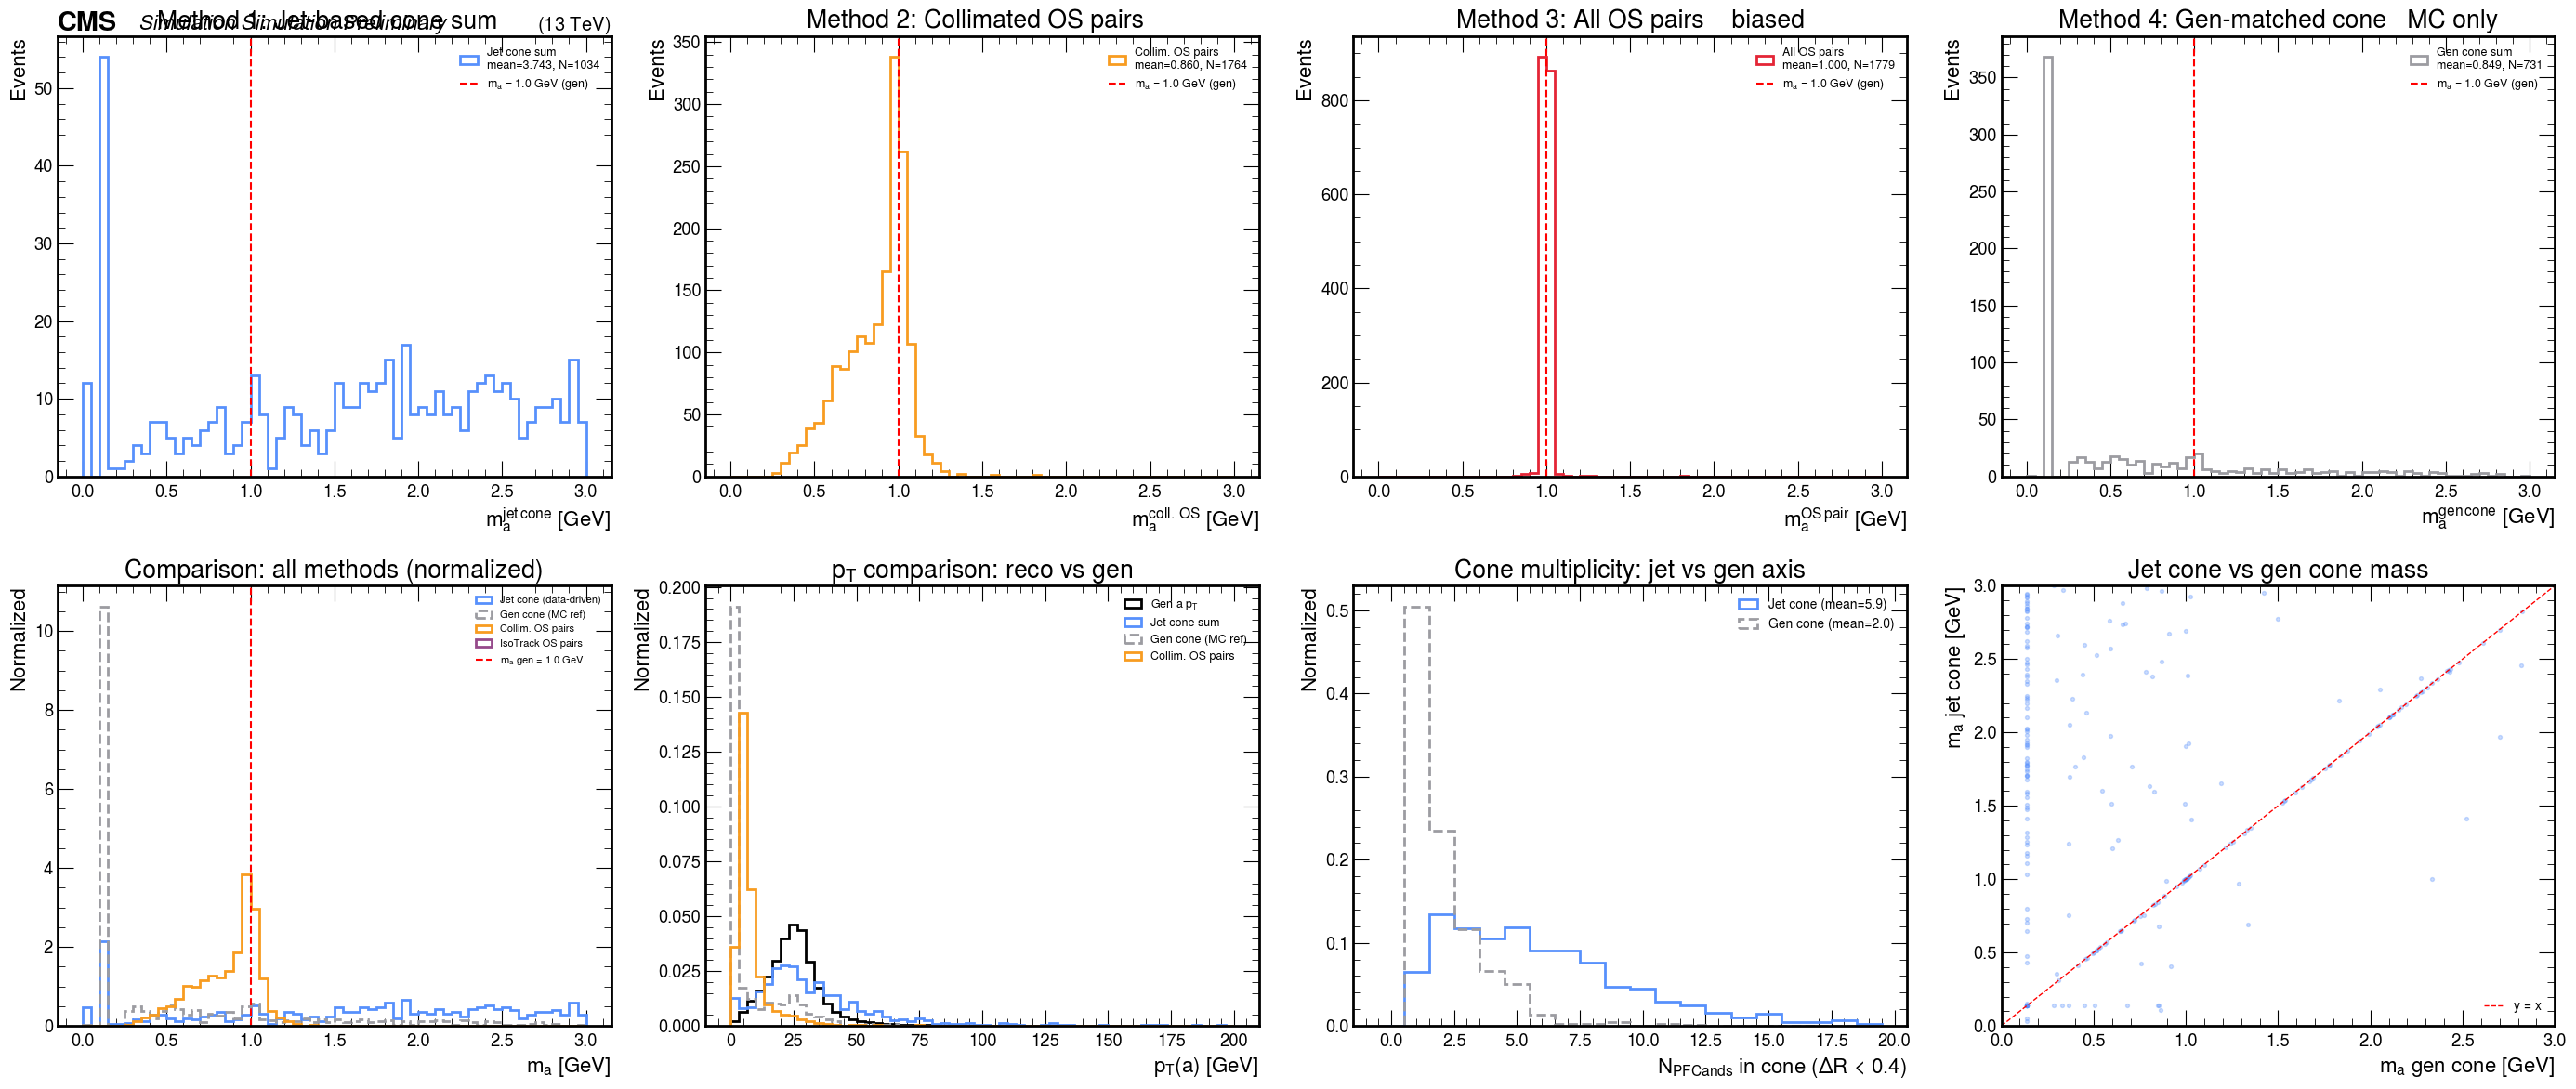


Figure: PFCands a-candidate reconstruction. Top: mass per method. Bottom: overlay, pT, cone multiplicity, jet vs gen cone correlation.


In [30]:
# ── PFCands a-candidate plots ───────────────────────────────────────────────────

fig, axes = plt.subplots(2, 4, figsize=(28, 12))

# ── Row 0: Mass distribution for each method ──────────────────────────────────

# [0,0] Jet-based cone mass (DATA-DRIVEN, primary)
ax = axes[0, 0]
m_jcone = ak.to_numpy(a_jet_cone_mass[has_a_jet_cone_reco])
if len(m_jcone) > 0:
    ax.hist(m_jcone, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C0",
            label=f"Jet cone sum\nmean={np.mean(m_jcone):.3f}, N={len(m_jcone)}")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV (gen)")
ax.set_xlabel("$m_a^{\\mathrm{jet\\,cone}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Method 1: Jet-based cone sum ✅")
ax.legend(fontsize=9)
hep.cms.label("Simulation Preliminary", ax=ax, data=False)

# [0,1] Collimated OS pairs mass
ax = axes[0, 1]
m_coll = ak.to_numpy(a_pf_coll_mass[has_a_pf_coll_reco])
if len(m_coll) > 0:
    ax.hist(m_coll, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C1",
            label=f"Collim. OS pairs\nmean={np.mean(m_coll):.3f}, N={len(m_coll)}")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV (gen)")
ax.set_xlabel("$m_a^{\\mathrm{coll.\\,OS}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Method 2: Collimated OS pairs ✅")
ax.legend(fontsize=9)

# [0,2] All OS pairs (biased baseline) mass
ax = axes[0, 2]
m_all = ak.to_numpy(a_pf_mass[has_a_pf_reco])
if len(m_all) > 0:
    ax.hist(m_all, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C2",
            label=f"All OS pairs\nmean={np.mean(m_all):.3f}, N={len(m_all)}")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV (gen)")
ax.set_xlabel("$m_a^{\\mathrm{OS\\,pair}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Method 3: All OS pairs ⚠️ biased")
ax.legend(fontsize=9)

# [0,3] Gen-matched cone mass (MC only)
ax = axes[0, 3]
m_gcone = ak.to_numpy(a_cone_mass[has_a_cone_reco])
if len(m_gcone) > 0:
    ax.hist(m_gcone, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C4",
            label=f"Gen cone sum\nmean={np.mean(m_gcone):.3f}, N={len(m_gcone)}")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV (gen)")
ax.set_xlabel("$m_a^{\\mathrm{gen\\,cone}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("Method 4: Gen-matched cone ❌ MC only")
ax.legend(fontsize=9)

# ── Row 1: Comparisons and diagnostics ────────────────────────────────────────

# [1,0] Overlay all methods — normalized mass
ax = axes[1, 0]
bins_m = np.linspace(0, 3.0, 61)
if len(m_jcone) > 0:
    ax.hist(m_jcone, bins=bins_m, histtype="step", linewidth=2, color="C0",
            density=True, label="Jet cone (data-driven)")
if len(m_gcone) > 0:
    ax.hist(m_gcone, bins=bins_m, histtype="step", linewidth=2, color="C4",
            density=True, linestyle="--", label="Gen cone (MC ref)")
if len(m_coll) > 0:
    ax.hist(m_coll, bins=bins_m, histtype="step", linewidth=2, color="C1",
            density=True, label="Collim. OS pairs")
m_iso = ak.to_numpy(a_cand_mass[has_a_reco])
if len(m_iso) > 0:
    ax.hist(m_iso, bins=bins_m, histtype="step", linewidth=2, color="C3",
            density=True, label="IsoTrack OS pairs")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ gen = {MASS_A} GeV")
ax.set_xlabel("$m_a$ [GeV]")
ax.set_ylabel("Normalized")
ax.set_title("Comparison: all methods (normalized)")
ax.legend(fontsize=8)

# [1,1] pT comparison (reco vs gen)
ax = axes[1, 1]
bins_pt = np.linspace(0, 200, 61)
gen_a_pt_vals = ak.to_numpy(ak.fill_none(ak.firsts(gen_a.pt), -999))
gen_a_pt_valid = gen_a_pt_vals[gen_a_pt_vals > 0]
ax.hist(gen_a_pt_valid, bins=bins_pt, histtype="step", linewidth=2, color="black",
        density=True, label="Gen $a$ $p_T$")
pt_jcone = ak.to_numpy(a_jet_cone_pt[has_a_jet_cone_reco])
if len(pt_jcone) > 0:
    ax.hist(pt_jcone, bins=bins_pt, histtype="step", linewidth=2, color="C0",
            density=True, label="Jet cone sum")
pt_gcone = ak.to_numpy(a_cone_pt[has_a_cone_reco])
if len(pt_gcone) > 0:
    ax.hist(pt_gcone, bins=bins_pt, histtype="step", linewidth=2, color="C4",
            density=True, linestyle="--", label="Gen cone (MC ref)")
pt_coll = ak.to_numpy(a_pf_coll_pt[has_a_pf_coll_reco])
if len(pt_coll) > 0:
    ax.hist(pt_coll, bins=bins_pt, histtype="step", linewidth=2, color="C1",
            density=True, label="Collim. OS pairs")
ax.set_xlabel("$p_T(a)$ [GeV]")
ax.set_ylabel("Normalized")
ax.set_title("$p_T$ comparison: reco vs gen")
ax.legend(fontsize=9)

# [1,2] PFCands multiplicity in jet cone vs gen cone
ax = axes[1, 2]
n_jc_arr = ak.to_numpy(n_in_jet_cone[has_a_jet_cone_reco])
n_gc_arr = ak.to_numpy(n_in_cone[has_a_cone_reco])
if len(n_jc_arr) > 0:
    ax.hist(n_jc_arr, bins=np.arange(-0.5, 20.5, 1), histtype="step", linewidth=2, color="C0",
            label=f"Jet cone (mean={np.mean(n_jc_arr):.1f})", density=True)
if len(n_gc_arr) > 0:
    ax.hist(n_gc_arr, bins=np.arange(-0.5, 20.5, 1), histtype="step", linewidth=2, color="C4",
            linestyle="--", label=f"Gen cone (mean={np.mean(n_gc_arr):.1f})", density=True)
ax.set_xlabel(f"$N_{{\\mathrm{{PFCands}}}}$ in cone (ΔR < {CONE_SIZE})")
ax.set_ylabel("Normalized")
ax.set_title("Cone multiplicity: jet vs gen axis")
ax.legend(fontsize=10)

# [1,3] Jet cone vs gen cone mass correlation
ax = axes[1, 3]
both_reco = has_a_jet_cone_reco & has_a_cone_reco
m_jc_both = ak.to_numpy(a_jet_cone_mass[both_reco])
m_gc_both = ak.to_numpy(a_cone_mass[both_reco])
if len(m_jc_both) > 0:
    ax.scatter(m_gc_both, m_jc_both, alpha=0.3, s=8, color="C0")
    ax.plot([0, 3], [0, 3], "r--", linewidth=1, label="y = x")
    ax.set_xlabel("$m_a$ gen cone [GeV]")
    ax.set_ylabel("$m_a$ jet cone [GeV]")
    ax.set_xlim(0, 3.0)
    ax.set_ylim(0, 3.0)
ax.set_title("Jet cone vs gen cone mass")
ax.legend(fontsize=10)

fig.tight_layout()
plt.show()
print(f"\nFigure: PFCands a-candidate reconstruction. Top: mass per method. "
      f"Bottom: overlay, pT, cone multiplicity, jet vs gen cone correlation.")

/tmp/pgadow/ipykernel_1244632/2350509315.py:103: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) TeX Gyre Heros.
  fig.tight_layout()
/tmp/pgadow/ipykernel_1244632/2350509315.py:103: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) TeX Gyre Heros.
  fig.tight_layout()
/tmp/pgadow/ipykernel_1244632/2350509315.py:103: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) TeX Gyre Heros.
  fig.tight_layout()


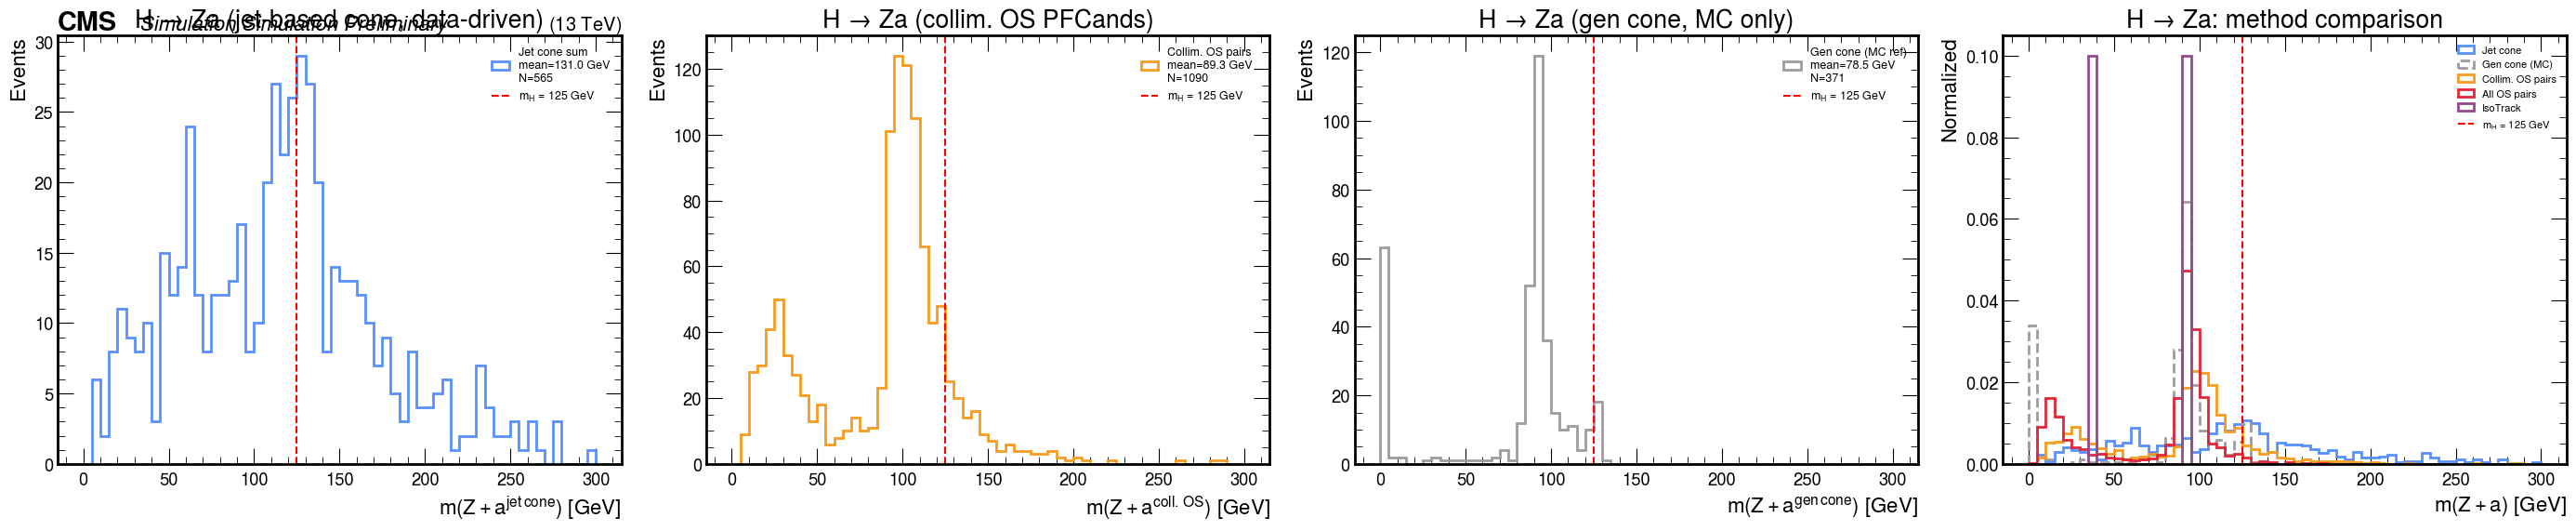


Figure: H → Za mass reconstruction comparison.
  Jet cone (data-driven): N=565, mean m_H = 131.0 GeV
  Collimated OS:          N=1090, mean m_H = 89.3 GeV
  All OS pairs:           N=1100, mean m_H = 73.9 GeV
  Gen cone (MC only):     N=371, mean m_H = 78.5 GeV
  IsoTrack:               N=2, mean m_H = 65.4 GeV


In [31]:
# ── H → Z a reconstruction using PFCands ────────────────────────────────────────
# Combine the reco Z with each PFCands a-candidate to reconstruct H.
# The jet-based cone sum is the primary data-driven method; the gen-matched
# cone serves as an MC-only validation reference.

fig, axes = plt.subplots(1, 4, figsize=(28, 6))

# Build Z 4-vector (same as used in IsoTrack H reconstruction)
z_vec = vector.zip({
    "pt": z_pt, "eta": z_eta, "phi": z_phi, "mass": z_mass,
})

# ── Method 1: Jet-based cone sum (primary, data-driven) ─────────────────────
a_jcone_4v = vector.zip({
    "pt": a_jet_cone_pt, "eta": a_jet_cone_eta,
    "phi": a_jet_cone_phi, "mass": a_jet_cone_mass,
})
h_jcone_sel = has_z & has_a_jet_cone_reco
h_jcone_4v = z_vec[h_jcone_sel] + a_jcone_4v[h_jcone_sel]
h_jcone_m = ak.to_numpy(h_jcone_4v.mass)
h_jcone_pt = ak.to_numpy(h_jcone_4v.pt)

ax = axes[0]
if len(h_jcone_m) > 0:
    ax.hist(h_jcone_m, bins=60, range=(0, 300), histtype="step", linewidth=2, color="C0",
            label=f"Jet cone sum ✅\nmean={np.mean(h_jcone_m):.1f} GeV\nN={len(h_jcone_m)}")
ax.axvline(125.0, color="red", linestyle="--", linewidth=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + a^{\\mathrm{jet\\,cone}})$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("H → Za (jet-based cone, data-driven)")
ax.legend(fontsize=9)
hep.cms.label("Simulation Preliminary", ax=ax, data=False)

# ── Method 2: Collimated OS pairs ────────────────────────────────────────────
a_coll_4v = vector.zip({
    "pt": a_pf_coll_pt, "eta": a_pf_coll_eta,
    "phi": a_pf_coll_phi, "mass": a_pf_coll_mass,
})
h_coll_sel = has_z & has_a_pf_coll_reco
h_coll_4v = z_vec[h_coll_sel] + a_coll_4v[h_coll_sel]
h_coll_m = ak.to_numpy(h_coll_4v.mass)

ax = axes[1]
if len(h_coll_m) > 0:
    ax.hist(h_coll_m, bins=60, range=(0, 300), histtype="step", linewidth=2, color="C1",
            label=f"Collim. OS pairs ✅\nmean={np.mean(h_coll_m):.1f} GeV\nN={len(h_coll_m)}")
ax.axvline(125.0, color="red", linestyle="--", linewidth=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + a^{\\mathrm{coll.\\,OS}})$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("H → Za (collim. OS PFCands)")
ax.legend(fontsize=9)

# ── Method 4: Gen-matched cone (MC validation only) ─────────────────────────
a_gcone_4v = vector.zip({
    "pt": a_cone_pt, "eta": a_cone_eta, "phi": a_cone_phi, "mass": a_cone_mass,
})
h_gcone_sel = has_z & has_a_cone_reco
h_gcone_4v = z_vec[h_gcone_sel] + a_gcone_4v[h_gcone_sel]
h_gcone_m = ak.to_numpy(h_gcone_4v.mass)

ax = axes[2]
if len(h_gcone_m) > 0:
    ax.hist(h_gcone_m, bins=60, range=(0, 300), histtype="step", linewidth=2, color="C4",
            label=f"Gen cone (MC ref)\nmean={np.mean(h_gcone_m):.1f} GeV\nN={len(h_gcone_m)}")
ax.axvline(125.0, color="red", linestyle="--", linewidth=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + a^{\\mathrm{gen\\,cone}})$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("H → Za (gen cone, MC only)")
ax.legend(fontsize=9)

# ── Overlay all methods ──────────────────────────────────────────────────────
a_all_4v = vector.zip({
    "pt": a_pf_pt, "eta": a_pf_eta, "phi": a_pf_phi, "mass": a_pf_mass,
})
h_all_sel = has_z & has_a_pf_reco
h_all_4v = z_vec[h_all_sel] + a_all_4v[h_all_sel]
h_all_m = ak.to_numpy(h_all_4v.mass)

ax = axes[3]
bins_h = np.linspace(0, 300, 61)
if len(h_jcone_m) > 0:
    ax.hist(h_jcone_m, bins=bins_h, histtype="step", linewidth=2, color="C0",
            density=True, label="Jet cone ✅")
if len(h_gcone_m) > 0:
    ax.hist(h_gcone_m, bins=bins_h, histtype="step", linewidth=2, color="C4",
            density=True, linestyle="--", label="Gen cone (MC)")
if len(h_coll_m) > 0:
    ax.hist(h_coll_m, bins=bins_h, histtype="step", linewidth=2, color="C1",
            density=True, label="Collim. OS pairs")
if len(h_all_m) > 0:
    ax.hist(h_all_m, bins=bins_h, histtype="step", linewidth=2, color="C2",
            density=True, label="All OS pairs ⚠️")
h_iso_m = h_cand_m  # already filtered to events with both Z and a candidates
if len(h_iso_m) > 0:
    ax.hist(h_iso_m, bins=bins_h, histtype="step", linewidth=2, color="C3",
            density=True, label="IsoTrack")
ax.axvline(125.0, color="red", linestyle="--", linewidth=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + a)$ [GeV]")
ax.set_ylabel("Normalized")
ax.set_title("H → Za: method comparison")
ax.legend(fontsize=8)

fig.tight_layout()
plt.show()

print(f"\nFigure: H → Za mass reconstruction comparison.")
if len(h_jcone_m) > 0:
    print(f"  Jet cone (data-driven): N={len(h_jcone_m)}, mean m_H = {np.mean(h_jcone_m):.1f} GeV")
if len(h_coll_m) > 0:
    print(f"  Collimated OS:          N={len(h_coll_m)}, mean m_H = {np.mean(h_coll_m):.1f} GeV")
if len(h_all_m) > 0:
    print(f"  All OS pairs:           N={len(h_all_m)}, mean m_H = {np.mean(h_all_m):.1f} GeV")
if len(h_gcone_m) > 0:
    print(f"  Gen cone (MC only):     N={len(h_gcone_m)}, mean m_H = {np.mean(h_gcone_m):.1f} GeV")
if len(h_iso_m) > 0:
    print(f"  IsoTrack:               N={len(h_iso_m)}, mean m_H = {np.mean(h_iso_m):.1f} GeV")

## Jet and MET Distributions

Basic jet and missing transverse energy distributions. Jets arise mainly from ISR/FSR activity.

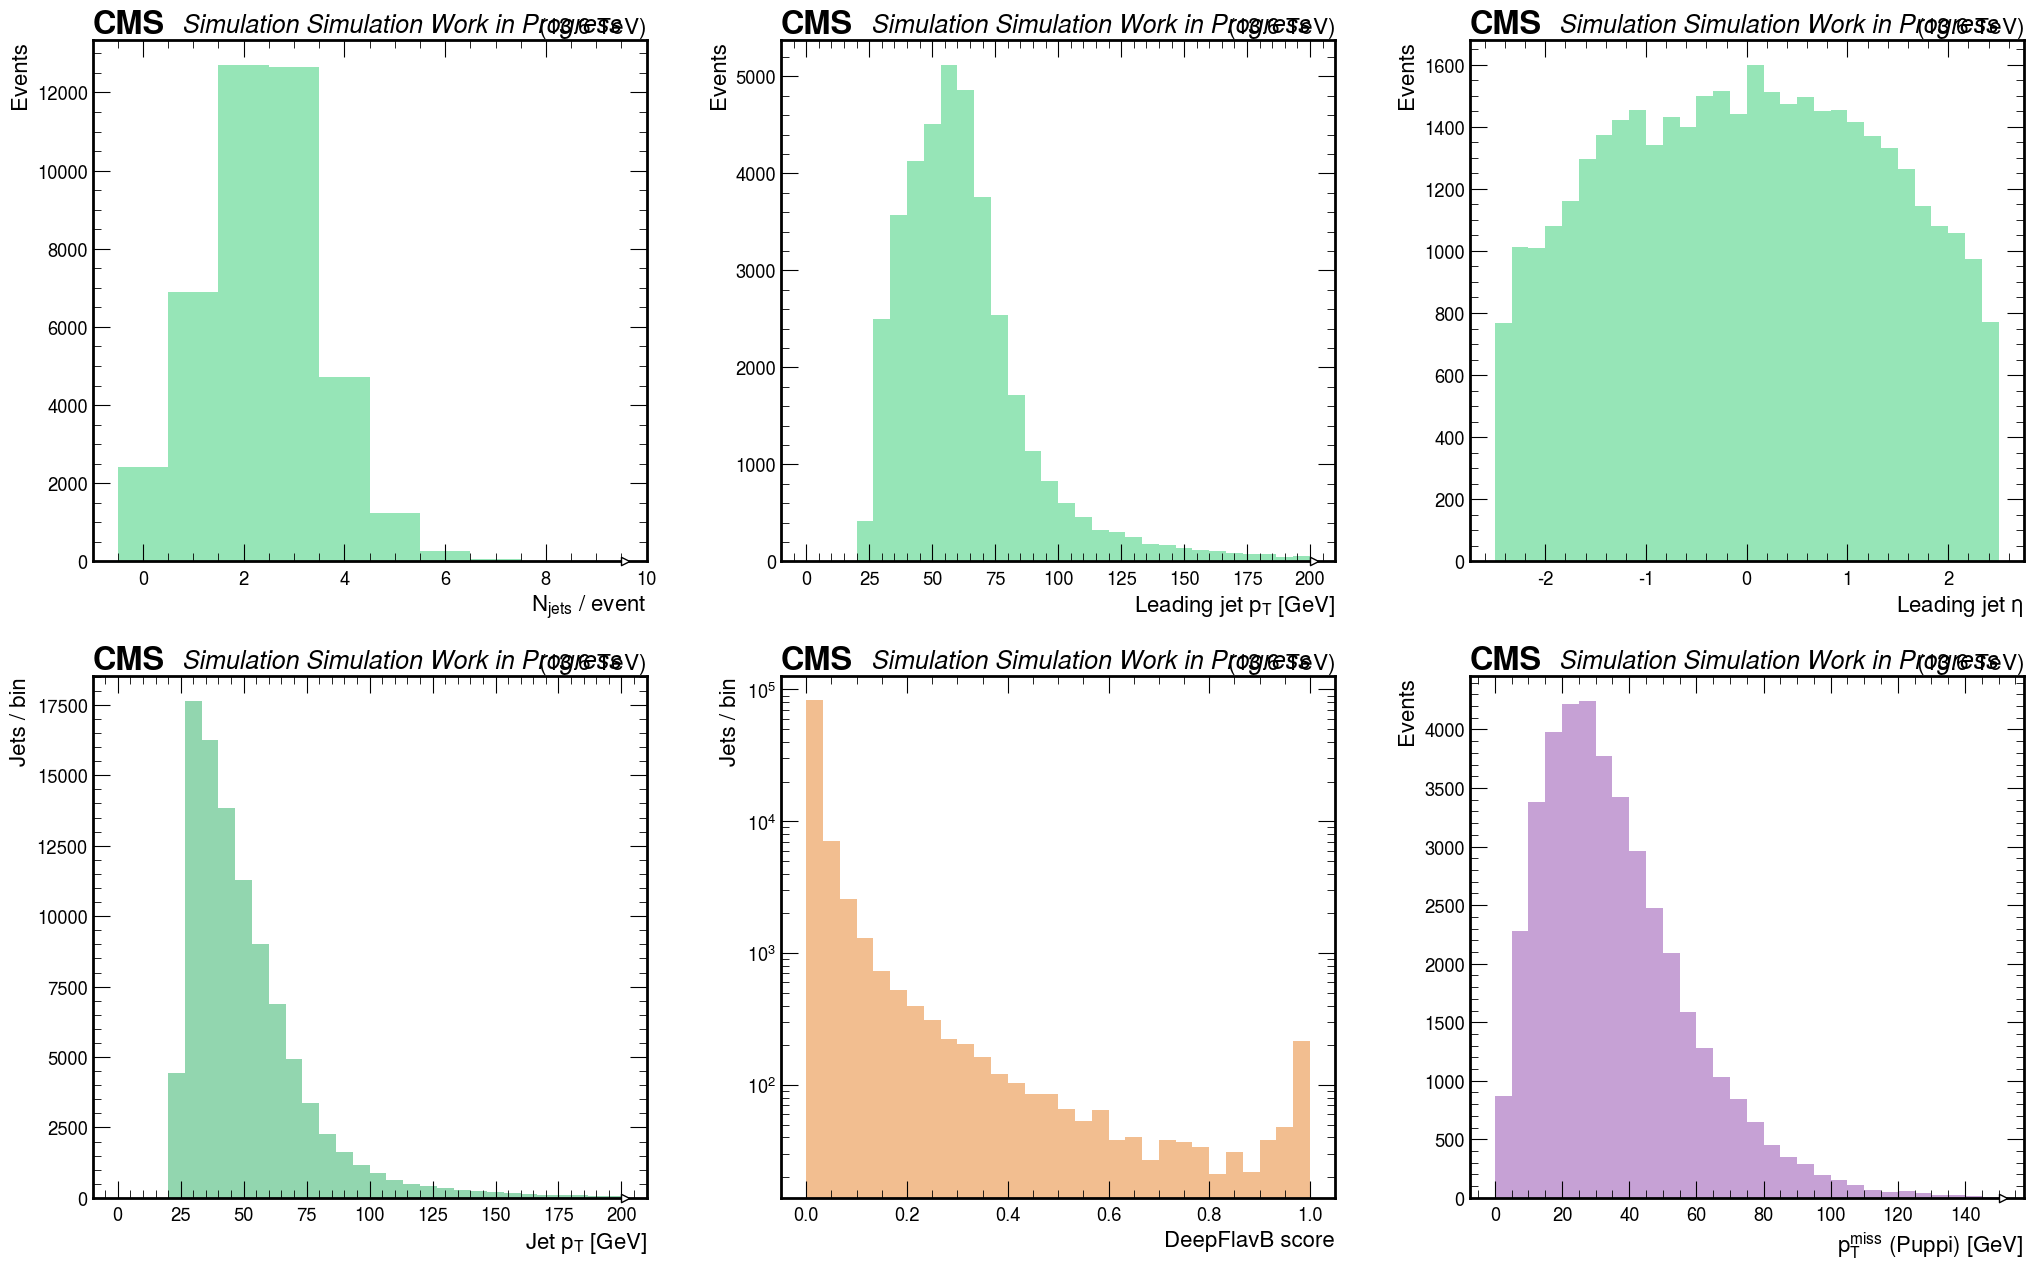

In [32]:
# ── Jet and MET plots ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Jet multiplicity
h = hist.Hist(hist.axis.Regular(10, -0.5, 9.5, label=r"$N_{\mathrm{jets}}$ / event"))
h.fill(ak.to_numpy(n_jet))
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 0].set_ylabel("Events")
cms_label(axes[0, 0])

# Leading jet pT
lead_jet_pt = ak.fill_none(ak.firsts(sel_jets.pt), -1)
has_jet = lead_jet_pt > 0
h = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Leading jet $p_T$ [GeV]"))
h.fill(ak.to_numpy(lead_jet_pt[has_jet]))
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 1].set_ylabel("Events")
cms_label(axes[0, 1])

# Leading jet eta
lead_jet_eta = ak.fill_none(ak.firsts(sel_jets.eta), -99)
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Leading jet $\eta$"))
h.fill(ak.to_numpy(lead_jet_eta[has_jet]))
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 2].set_ylabel("Events")
cms_label(axes[0, 2])

# All jet pT
all_jet_pt = ak.flatten(sel_jets.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Jet $p_T$ [GeV]"))
h.fill(all_jet_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#27ae60", edgecolor="#27ae60")
axes[1, 0].set_ylabel("Jets / bin")
cms_label(axes[1, 0])

# b-tag score (DeepFlavour)
all_btag = ak.flatten(sel_jet_btag).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 1, label="DeepFlavB score"))
h.fill(all_btag)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[1, 1].set_ylabel("Jets / bin")
axes[1, 1].set_yscale("log")
cms_label(axes[1, 1])

# PuppiMET
met_pt = ak.to_numpy(events.PuppiMET_pt)
h = hist.Hist(hist.axis.Regular(30, 0, 150, label=r"$p_T^{\mathrm{miss}}$ (Puppi) [GeV]"))
h.fill(met_pt)
hep.histplot(h, ax=axes[1, 2], histtype="fill", alpha=0.5, color="#8e44ad", edgecolor="#8e44ad")
axes[1, 2].set_ylabel("Events")
cms_label(axes[1, 2])

save_and_show(fig, "reco_jets_met.png")

## Event-Level Observables

Scalar sum of jet $p_T$ ($H_T$), total visible transverse momentum, and combined event-level quantities.

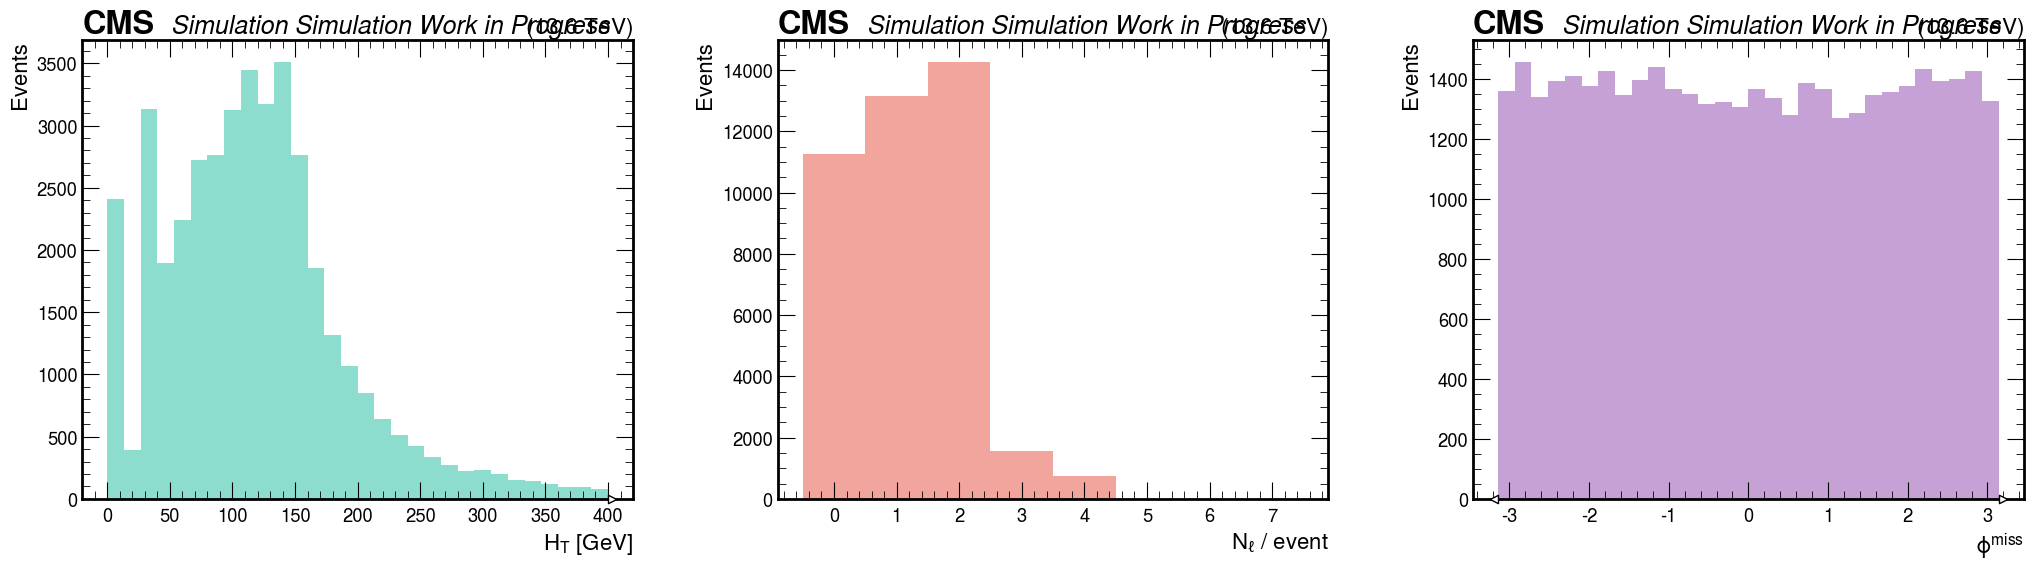

In [33]:
# ── Event-level observables ────────────────────────────────────────────────────
# HT = scalar sum of jet pT
ht = ak.sum(sel_jets.pt, axis=1)

# Total lepton multiplicity
n_lep_total = n_mu + n_el

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# HT
h = hist.Hist(hist.axis.Regular(30, 0, 400, label=r"$H_T$ [GeV]"))
h.fill(ak.to_numpy(ht))
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[0].set_ylabel("Events")
cms_label(axes[0])

# Total lepton multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\ell}$ / event"))
h.fill(ak.to_numpy(n_lep_total))
hep.histplot(h, ax=axes[1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1].set_ylabel("Events")
cms_label(axes[1])

# MET phi
met_phi = ak.to_numpy(events.PuppiMET_phi)
h = hist.Hist(hist.axis.Regular(30, -np.pi, np.pi, label=r"$\phi^{\mathrm{miss}}$"))
h.fill(met_phi)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#8e44ad", edgecolor="#8e44ad")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "event_level.png")

## Generator vs Reconstruction Comparison

Compare gen-level and reco-level Z boson mass and $p_T$ to assess reconstruction performance.

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer wei

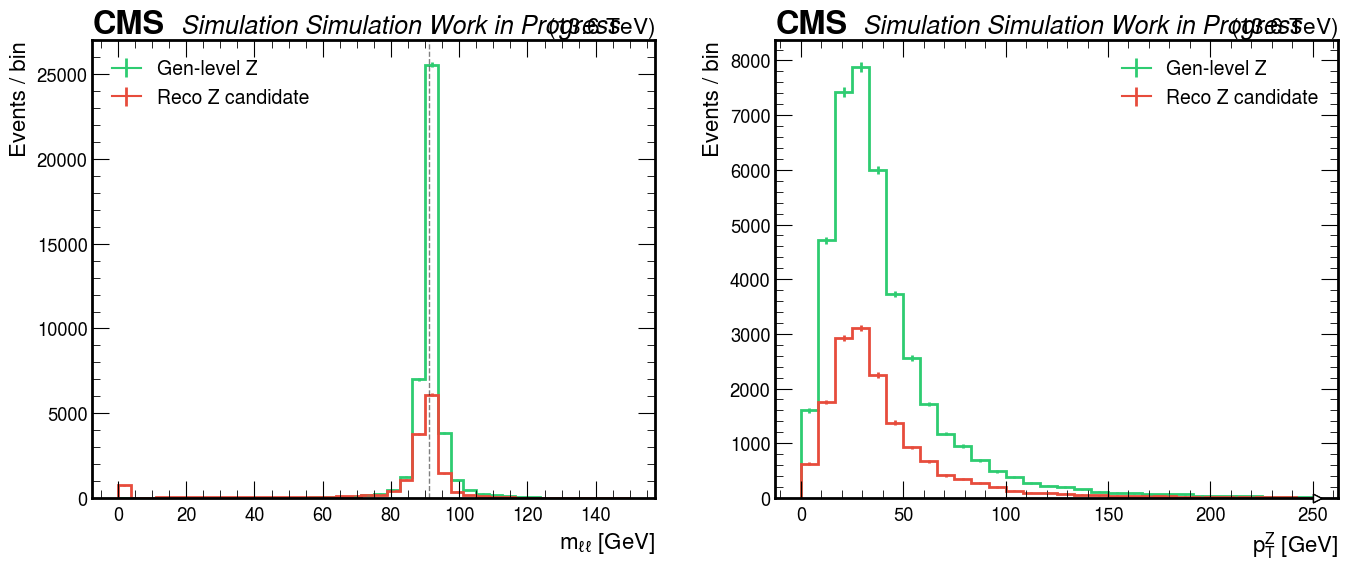

In [35]:
# ── Gen vs Reco comparison ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Z mass: gen vs reco
h_gen = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_reco = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_gen.fill(z_m)
h_reco.fill(z_mass_arr)
hep.histplot(h_gen, ax=axes[0], histtype="step", linewidth=2, color="#2ecc71", label="Gen-level Z")
hep.histplot(h_reco, ax=axes[0], histtype="step", linewidth=2, color="#e74c3c", label="Reco Z candidate")
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[0].set_ylabel("Events / bin")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# Z pT: gen vs reco
h_gen_pt = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_reco_pt = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_gen_pt.fill(z_pt_gen := ak.flatten(gen_Z.pt).to_numpy())
h_reco_pt.fill(z_pt_arr)
hep.histplot(h_gen_pt, ax=axes[1], histtype="step", linewidth=2, color="#2ecc71", label="Gen-level Z")
hep.histplot(h_reco_pt, ax=axes[1], histtype="step", linewidth=2, color="#e74c3c", label="Reco Z candidate")
axes[1].set_ylabel("Events / bin")
axes[1].legend(fontsize=14)
cms_label(axes[1])

save_and_show(fig, "gen_vs_reco_z.png")

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer wei

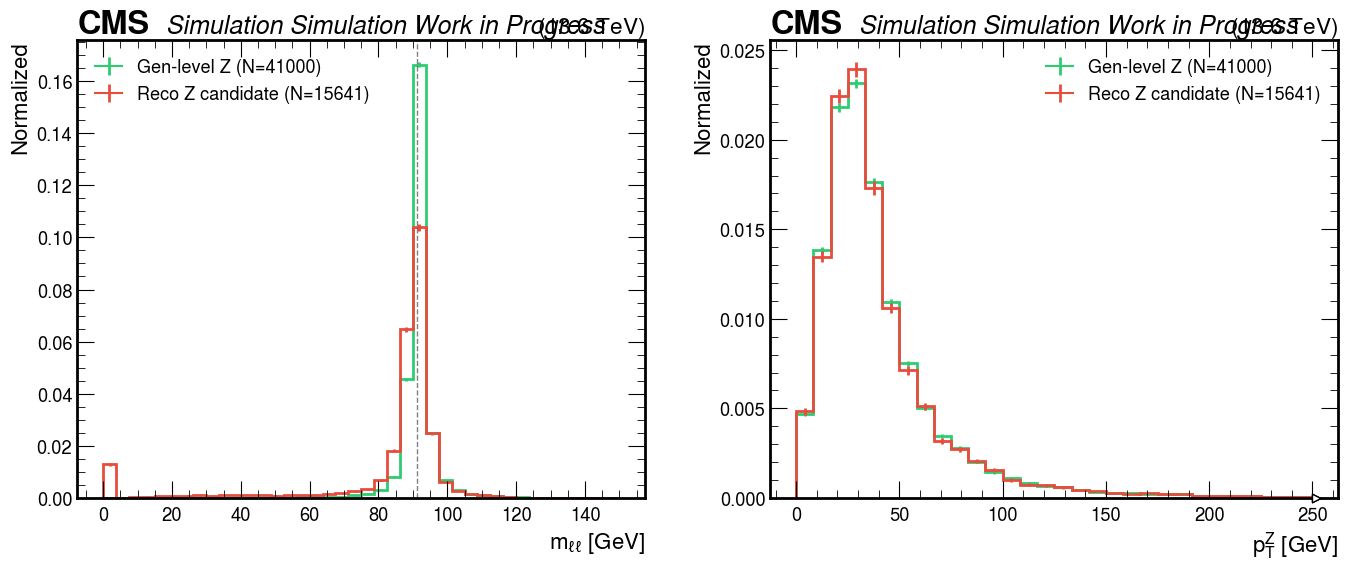

In [36]:
# ── Gen vs Reco comparison (normalized to unit area) ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Z mass: gen vs reco (normalized)
h_gen_n = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_reco_n = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_gen_n.fill(z_m)
h_reco_n.fill(z_mass_arr)
hep.histplot(h_gen_n, ax=axes[0], histtype="step", linewidth=2, color="#2ecc71",
             label=f"Gen-level Z (N={len(z_m)})", density=True)
hep.histplot(h_reco_n, ax=axes[0], histtype="step", linewidth=2, color="#e74c3c",
             label=f"Reco Z candidate (N={len(z_mass_arr)})", density=True)
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[0].set_ylabel("Normalized")
axes[0].legend(fontsize=13)
cms_label(axes[0])

# Z pT: gen vs reco (normalized)
h_gen_pt_n = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_reco_pt_n = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_gen_pt_n.fill(z_pt_gen)
h_reco_pt_n.fill(z_pt_arr)
hep.histplot(h_gen_pt_n, ax=axes[1], histtype="step", linewidth=2, color="#2ecc71",
             label=f"Gen-level Z (N={len(z_pt_gen)})", density=True)
hep.histplot(h_reco_pt_n, ax=axes[1], histtype="step", linewidth=2, color="#e74c3c",
             label=f"Reco Z candidate (N={len(z_pt_arr)})", density=True)
axes[1].set_ylabel("Normalized")
axes[1].legend(fontsize=13)
cms_label(axes[1])

save_and_show(fig, "gen_vs_reco_z_normalized.png")